## Install CatBoost

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.8 MB/s eta 0:00:00


### Impotrt the required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import shap
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [ ]:
df=pd.read_csv('/content/All Graduated spreadsheet - Sheet1 (1) - All Graduated spreadsheet - Sheet1 (1).csv')

### Drop personal identifiers

In [ ]:
df.drop(columns = ['Similar','Status','First Name','Middle Name','Last Name','Full name','Reg No','UFA Reg No'], inplace=True)

In [ ]:
print(df.head().to_string())

                        Class ID   Branch  Gender        DOB   County   Sub_County               Location  Height  Weight Education_Level Primary/Highschool_Grade  Course School  Yearof Class  Handout 1 Score  Handout 2 Score  Handout 3 Score  Handout 4 Score  Handout 5 Score  Handout 6 Score  Handout 7 Score  Handout 8 Score  Handout 9 Score  Handout 10 score  CAT 1  CAT 2  CAT 3  CAT 4  CAT 5  CAT 6  Hand Hygiene  Gloving  Denture Cleaning  Oral Care  Oral Care(Unconscious)  Hand and Feet Care  Bed Making  Positioning  Back Care  ROM  Wheel Chair Transfer  Wound Care  Sponge Bath  Perineal Care  Hair Care  Fall Prevention  Dressing  Tube Feeding  Daiper Change  Catheter Care  Bed Pan  Vitals  Giving Oxygen  Blood Sugar Test  Insulin Injection  Administrating Meds  CPR  Use of Medical Equipment  Shaving  Entry Test  Attendance(Week 1)  Attendance(Week 2)  Attendance(Week 3)  Attendance(Week 4)  Attendance(Week 5)  Attendance(Week 6)  Attendance(Week 7)              Hospital Internship

### Explore the dataset

In [ ]:
df.dtypes

,0
Class ID,object
Branch,object
Gender,object
DOB,object
County,object
...,...
"Care of the Ear, Nose and Nails of the Baby",float64
Feeding,float64
Start Date of Class,object
End Date of Class,object


In [ ]:
df.shape

(2394, 85)

### Check for Null values

In [ ]:
df.isnull().sum()

,0
Class ID,127
Branch,157
Gender,157
DOB,158
County,157
...,...
"Care of the Ear, Nose and Nails of the Baby",394
Feeding,394
Start Date of Class,540
End Date of Class,543


### Create two Courses from the Class Id

In [ ]:
df["Course"] = df["Class ID"].apply(
    lambda x: "Childcare" if "Childcare" in str(x)
    else "Eldercare"
)


### Data Cleaning

In [ ]:
df['Final Grade'].replace({'FAIL': 'Fail', 'DISTINCTION': 'Distinction', 'PASS': 'Pass', 'CREDIT': 'Credit', 'HIGHER CREDIT': 'Higher Credit'}, inplace=True)

In [ ]:
df['County'].replace({"Null":'Nairobi'}, inplace=True)

In [ ]:
df['Location'].replace({'Null':'Kangemi'},inplace=True)

In [ ]:
df['Location'].describe()

,Location
count,2237
unique,615
top,Kangemi
freq,94


In [ ]:
df['Yearof Class'] = df['Yearof Class'].fillna(2025).astype(int)

In [ ]:
df['Transitioned_to_Caregiving'].fillna("Didn't Transition", inplace=True)

In [ ]:
df.rename(columns={'Yearof Class': 'Year of Class'}, inplace=True)
df['Year of Class'] = df['Year of Class'].astype(int)

### Convert date to datetime format

In [ ]:
df['Start Date of Class'] = pd.to_datetime(df['Start Date of Class'])
df['End Date of Class'] = pd.to_datetime(df['End Date of Class'])

### Convert the numerical features presented as categorical to numeric.

In [ ]:
df['Theory Exam - Icare'] = pd.to_numeric(df['Theory Exam - Icare'], errors='coerce')
df['Practical Scores /80 - Icare'] = pd.to_numeric(df['Practical Scores /80 - Icare'], errors='coerce')
df['Viva Scores /20 - Icare'] = pd.to_numeric(df['Viva Scores /20 - Icare'], errors='coerce')
df['Hospital Internship Score'] = pd.to_numeric(df['Hospital Internship Score'], errors='coerce')
df['Final Score'] = pd.to_numeric(df['Final Score'], errors='coerce')


In [ ]:
df['Education_Level'].fillna('High School', inplace=True)
df['Primary/Highschool_Grade'].fillna('D', inplace=True)

### Replace the null values with mean and mode

In [ ]:
# Numerical columns - use .mean()
df['Height'].fillna(df['Height'].mean(), inplace=True)
df['Weight'].fillna(df['Weight'].mean(), inplace=True)
df['Theory Exam - Icare'].fillna(df['Theory Exam - Icare'].mean(), inplace=True)
df['Practical Scores /80 - Icare'].fillna(df['Practical Scores /80 - Icare'].mean(), inplace=True)
df['Viva Scores /20 - Icare'].fillna(df['Viva Scores /20 - Icare'].mean(), inplace=True)
df['Hospital Internship Score'].fillna(df['Hospital Internship Score'].mean(), inplace=True)
df['Final Score'].fillna(df['Final Score'].mean(), inplace=True)

# Categorical columns - use .mode()[0]
df['Sub_County'].fillna(df['Sub_County'].mode()[0], inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)
df['Hospital Internship Attended'].fillna(df['Hospital Internship Attended'].mode()[0], inplace=True)
df['Final Grade'].fillna(df['Final Grade'].mode()[0], inplace=True)
df['Start Date of Class'].fillna(df['Start Date of Class'].mode()[0], inplace=True)
df['End Date of Class'].fillna(df['End Date of Class'].mode()[0], inplace=True)

### Correct formating of different feature values

In [ ]:
df['Transitioned_to_Caregiving'].replace(['Transitioned_to_Caregiving','Transitioned to care'], 'Transitioned to Care', inplace=True)
df["Transitioned_to_Caregiving"].replace({"Not Found": "Didn't Transition"}, inplace=True)
df['Education_Level'].replace({'Highschool': 'High School'}, inplace=True)
df['County'].replace({'Trans Nzoia': 'Trans-Nzoia'}, inplace=True)

### Exploratory Data Analysis

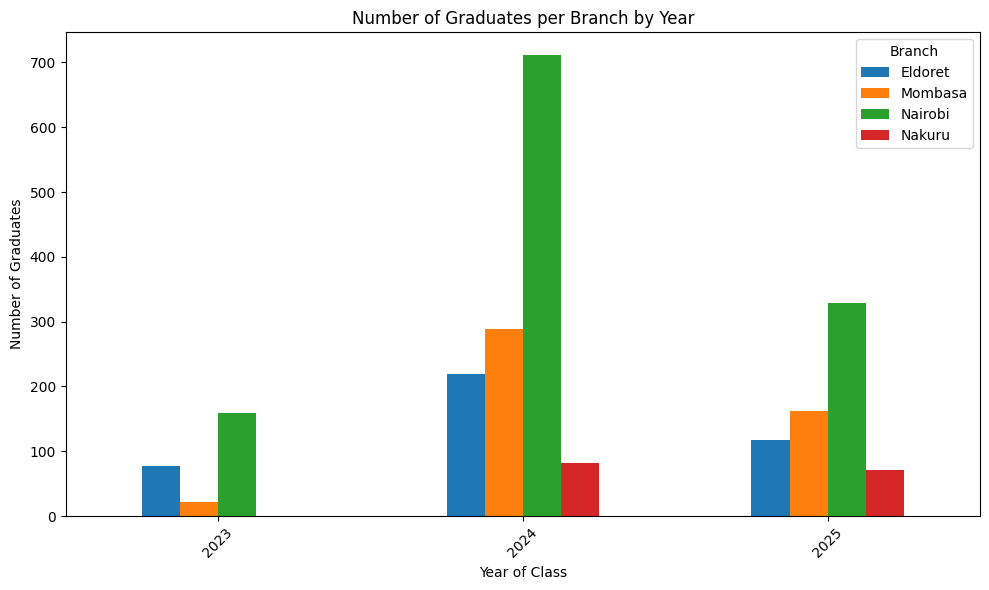

In [ ]:
# Group by Year of Class and Branch, then count graduates
graduates_per_branch = df.groupby(['Year of Class', 'Branch']).size().unstack()
graduates_per_branch.plot(kind='bar', figsize=(10,6))

plt.xlabel('Year of Class')
plt.ylabel('Number of Graduates')
plt.title('Number of Graduates per Branch by Year')
plt.legend(title='Branch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Transition rate by Course

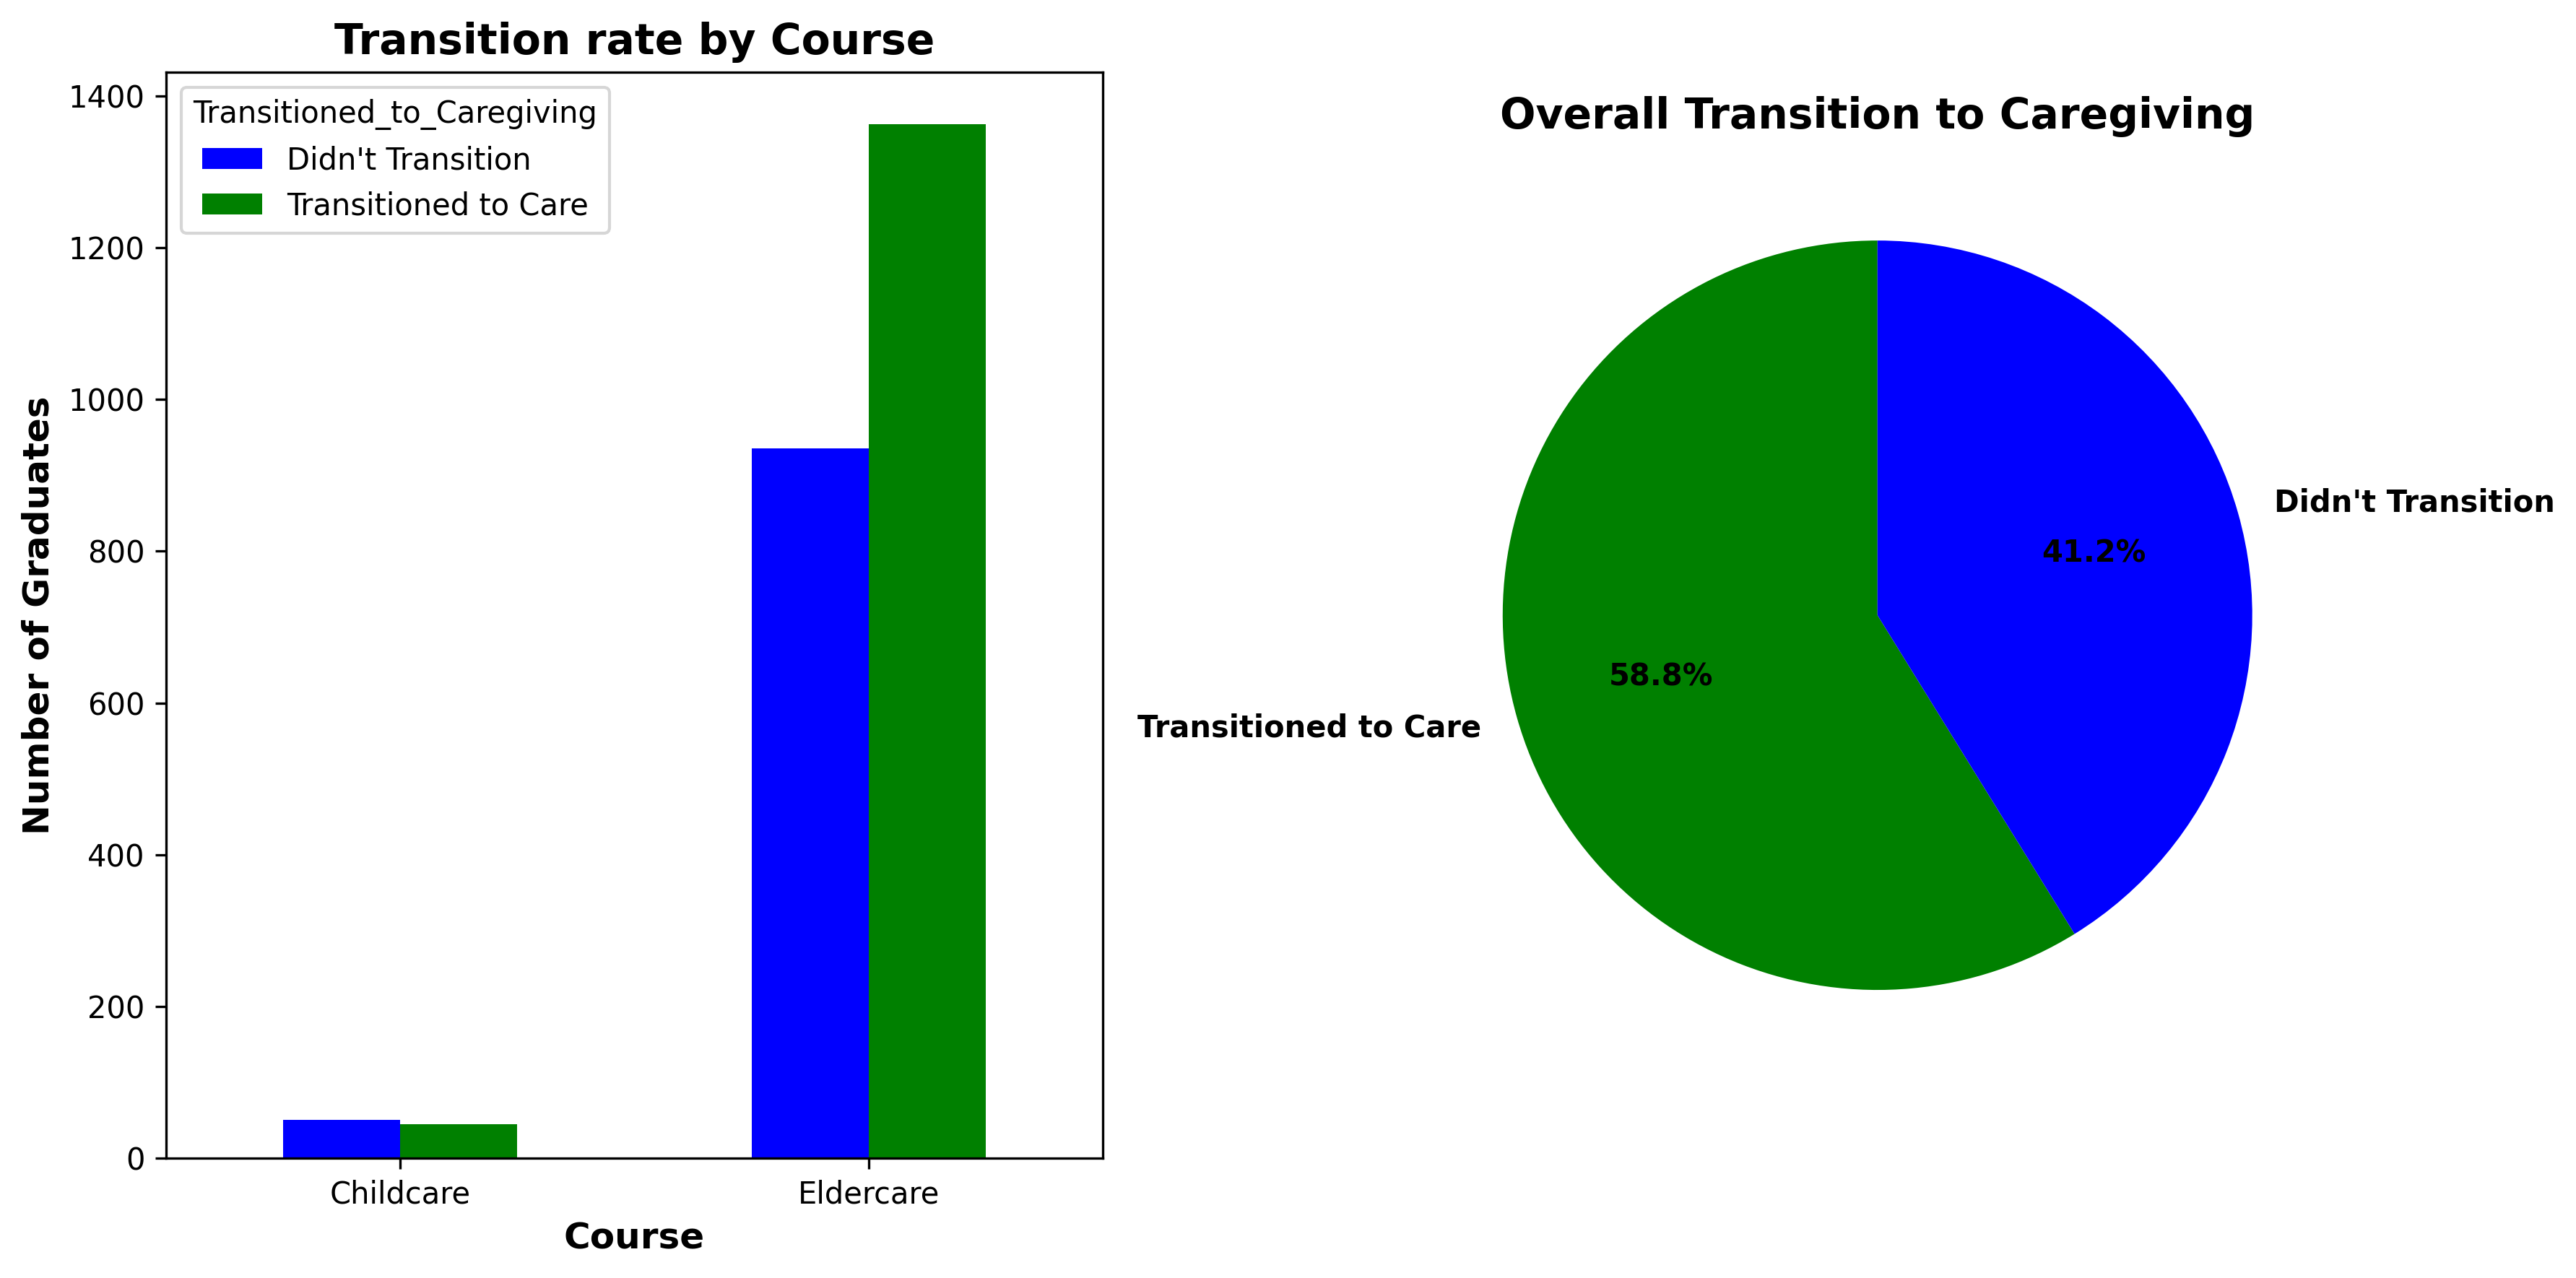

In [ ]:
transition_data = df.groupby(['Course', 'Transitioned_to_Caregiving']).size().unstack()
transition_overall = df['Transitioned_to_Caregiving'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

transition_data.plot(kind='bar', ax=axes[0], color=['blue', 'green'])
axes[0].set_title('Transition rate by Course', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Course', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Graduates', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

transition_overall.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    ax=axes[1],
    colors=['green', 'blue'],
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
axes[1].set_title('Overall Transition to Caregiving', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig("transition_to_caregiving.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()


### Number of graduates per course

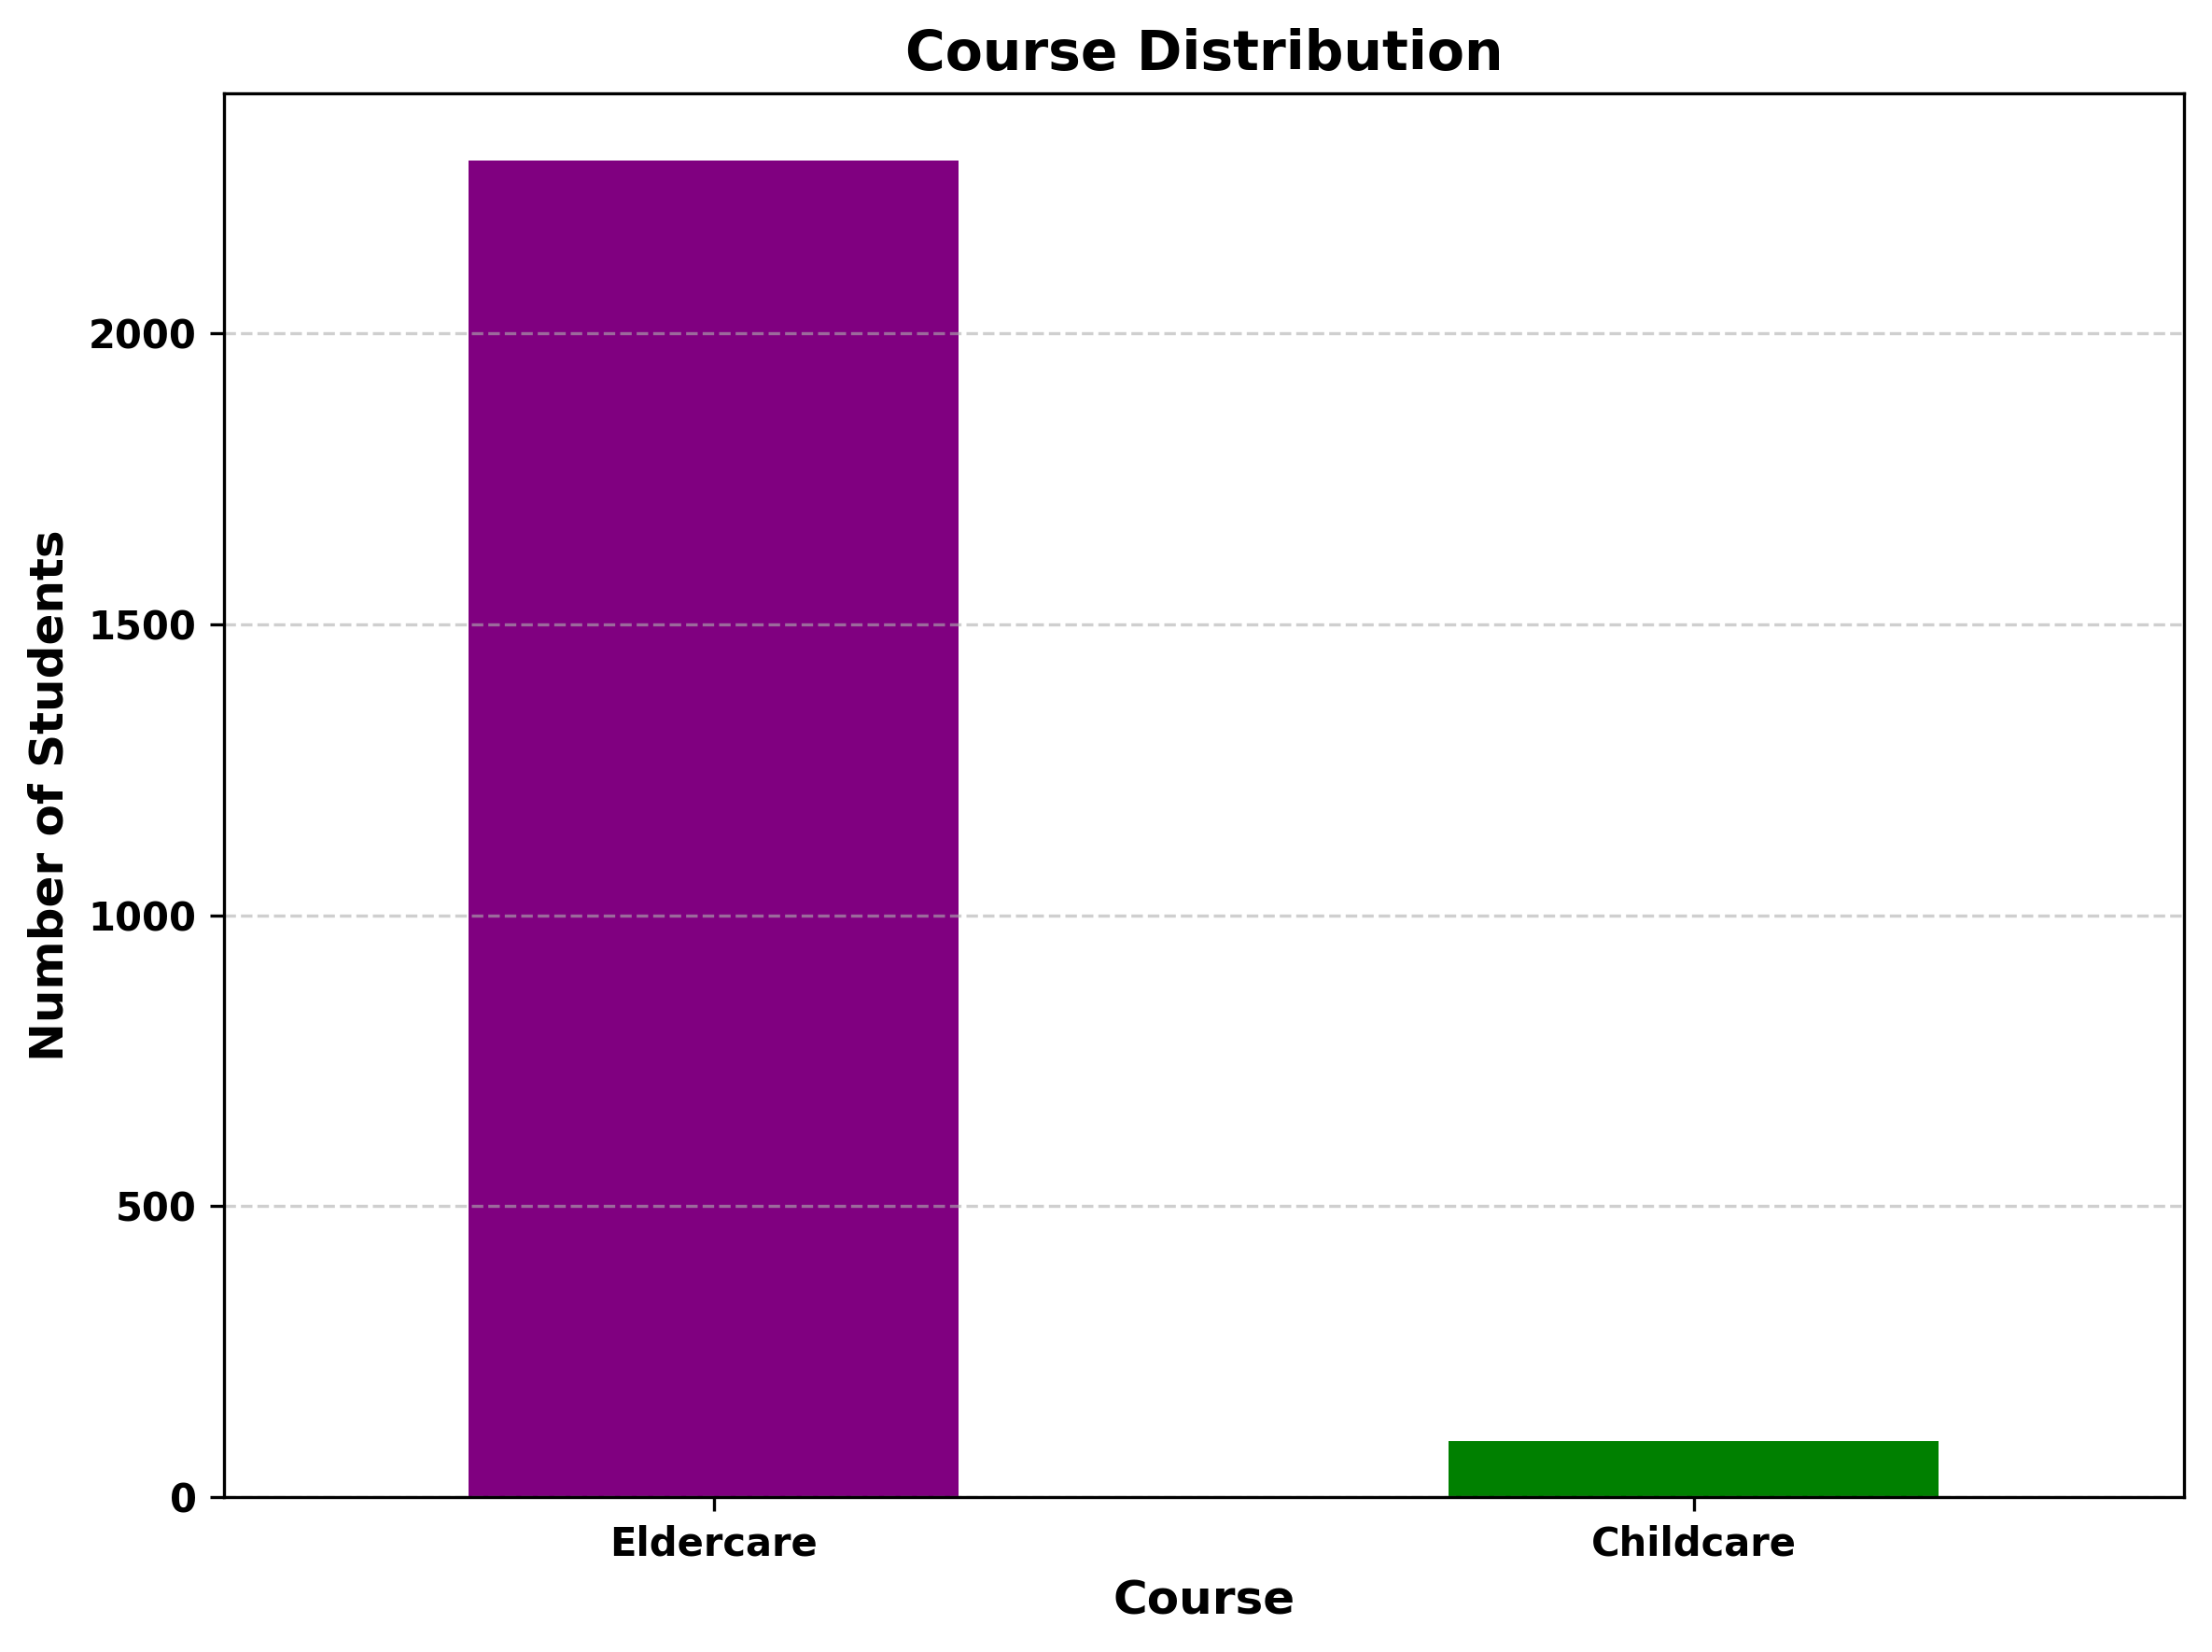

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
df['Course'].value_counts().plot(kind='bar', color=['purple', 'green'], ax=ax)
plt.xlabel('Course', fontsize=12, fontweight='bold')
plt.ylabel('Number of Students', fontsize=12, fontweight='bold')
plt.title('Course Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("course_distribution.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()


In [ ]:
df = df[~df['Class ID'].str.startswith('Exam', na=False)]


### Feature Engineering

In [ ]:
attendance_columns = ['Attendance(Week 1)', 'Attendance(Week 2)', 'Attendance(Week 3)', 'Attendance(Week 4)', 'Attendance(Week 5)', 'Attendance(Week 6)', 'Attendance(Week 7)']
df['Average Attendance'] = df[attendance_columns].mean(axis=1)
df['Average Attendance'] = df['Average Attendance'].round(0)

In [ ]:
cat_columns = ['CAT 1', 'CAT 2', 'CAT 3', 'CAT 4', 'CAT 5', 'CAT 6']

df['Average Cats'] = np.where(
    df['Class ID'].str.contains('Childcare', case=False, na=False),
    (df[cat_columns[:4]].mean(axis=1)).round(0),   # Average first 4 CATs
    (df[cat_columns].mean(axis=1)).round(0)         # Average all 6 CATs
)


In [ ]:
handout_columns = [
    'Handout 1 Score', 'Handout 2 Score', 'Handout 3 Score', 'Handout 4 Score',
    'Handout 5 Score', 'Handout 6 Score', 'Handout 7 Score', 'Handout 8 Score',
    'Handout 9 Score', 'Handout 10 score'
]

df['Average Handouts'] = np.where(
    df['Class ID'].str.contains('Childcare', case=False, na=False),
    0,  # Childcare students don't have handouts
    (df[handout_columns].mean(axis=1)).round(0)   # Average for others
)


In [ ]:
df['Blood Sugar Test'] = df['Blood Sugar Test'].replace(33, 3)

In [ ]:
# Columns for general practicals (Eldercare, etc.)
practical_columns = [
    'Hand Hygiene', 'Gloving', 'Denture Cleaning', 'Oral Care', 'Oral Care(Unconscious)',
    'Hand and Feet Care', 'Bed Making', 'Positioning', 'Back Care', 'ROM', 'Wheel Chair Transfer',
    'Wound Care', 'Sponge Bath', 'Perineal Care', 'Hair Care', 'Fall Prevention', 'Dressing',
    'Tube Feeding', 'Daiper Change', 'Catheter Care', 'Bed Pan', 'Vitals', 'Giving Oxygen',
    'Blood Sugar Test', 'Insulin Injection', 'Administrating Meds', 'CPR',
    'Use of Medical Equipment', 'Shaving'
]

# Columns for childcare-specific practicals
childcare_practicals = [
    'Hand Hygiene', 'Gloving', 'Bed Making', 'Sponge Bath', 'Daiper Change', 'Vitals',
    'Administrating Meds', 'Paediatric Advanced Life Support(PALS)', 'Toilet Assistance',
    'Dressing the Baby', 'Using the Stroller', 'Supporting the Baby in Walker',
    'Latching the Baby', 'Care of the Ear, Nose and Nails of the Baby', 'Feeding'
]

# Compute and round to whole number
df['Average Practicals'] = np.where(
    df['Class ID'].str.contains('Childcare', case=False, na=False),
    ((df[childcare_practicals].sum(axis=1) / 45) * 100).round(0),  # Childcare-specific
    ((df[practical_columns].sum(axis=1) / 87) * 100).round(0)       # General practicals
).astype(int)


In [ ]:
df['Entry Test'].fillna(df['Entry Test'].mean(), inplace=True)
df['Average Attendance'].fillna(df['Average Attendance'].mean(), inplace=True)

In [ ]:
df['Practical-Icare'] = df['Practical Scores /80 - Icare'] + df['Viva Scores /20 - Icare']

### Course Duration from class start and End date

In [ ]:
df['Course Duration'] = (df['End Date of Class'] - df['Start Date of Class']).dt.days
df['Course Duration Months'] = ((df['Course Duration'] / 30).round()).astype(int)

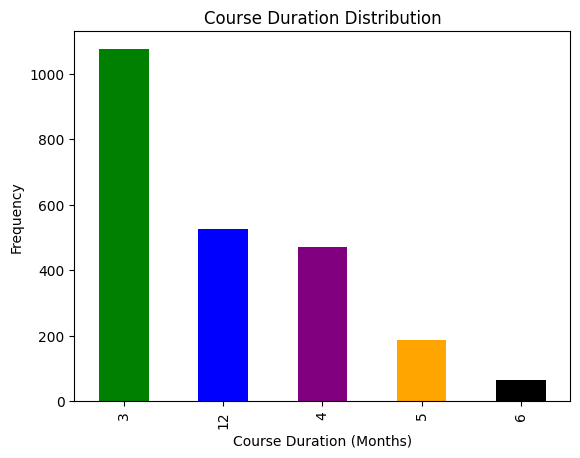

In [ ]:
total = df['Course Duration Months'].value_counts().head(5)
total.plot(
    kind='bar',
    color=['green', 'blue', 'purple', 'orange', 'black']
)

plt.xlabel('Course Duration (Months)')
plt.ylabel('Frequency')
plt.title('Course Duration Distribution')
plt.show()


### Drop redundant features after feature engineering

In [ ]:
df.drop(columns =['Hand Hygiene','Gloving','Denture Cleaning','Oral Care','Oral Care(Unconscious)',
                  'Hand and Feet Care','Bed Making','Positioning','Back Care','ROM','Wheel Chair Transfer',
                  'Wound Care','Sponge Bath','Perineal Care','Hair Care','Fall Prevention','Dressing',
                  'Tube Feeding','Daiper Change','Catheter Care','Bed Pan','Vitals','Giving Oxygen',
                  'Blood Sugar Test','Insulin Injection','Administrating Meds','CPR',
                  'Use of Medical Equipment','Shaving', 'Handout 1 Score',
                  'Handout 2 Score','Handout 3 Score','Handout 4 Score',
                  'Handout 5 Score','Handout 6 Score','Handout 7 Score','Handout 8 Score',
                  'Handout 9 Score','Handout 10 score', 'CAT 1','CAT 2','CAT 3',
                  'CAT 4','CAT 5','CAT 6', 'Attendance(Week 1)', 'Attendance(Week 2)',
                  'Attendance(Week 3)', 'Attendance(Week 4)', 'Attendance(Week 5)',
                  'Attendance(Week 6)', 'Attendance(Week 7)',
                  'Paediatric Advanced Life Support(PALS)',
                  'Toilet Assistance', 'Practical Scores /80 - Icare', 'Viva Scores /20 - Icare',
                  'Dressing the Baby', 'Using the Stroller', 'Supporting the Baby in Walker',
                  'Latching the Baby', 'Care of the Ear, Nose and Nails of the Baby',
                  'Feeding','End Date of Class','Start Date of Class'],inplace=True)

In [ ]:
df1 =df.copy()

In [ ]:
df1.shape

(2375, 28)

### Extract Age from Date of Birth

In [ ]:
df1['DOB'] = pd.to_datetime(df1['DOB'], errors='coerce')

### Extract Year of Birth from DOB

In [ ]:
df1['Year of Birth'] = df1['DOB'].dt.year

### Calculate the Age from Year of Birth

In [ ]:
df1['Age'] = 2025 - df1['Year of Birth']

In [ ]:
df1.drop(columns=['DOB','Year of Birth'], inplace=True)

### Classify Age into Age Groups

In [ ]:
bins = [17, 24, 34, 44, 54, 65]
labels = ['18–24', '25–34', '35–44', '45–54', '55–60']
df1['Age Group'] = pd.cut(df1['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

###  Analysis



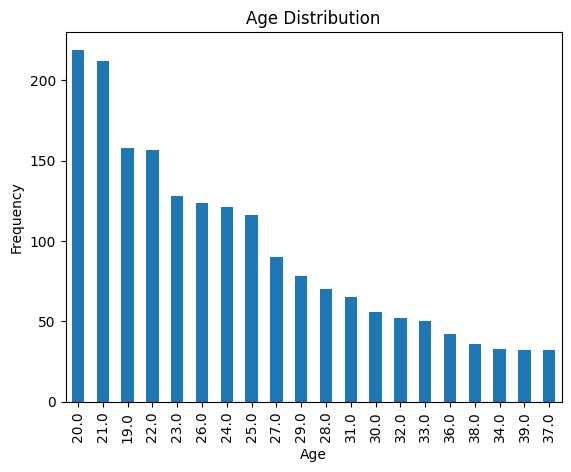

In [ ]:
df1['Age'].value_counts().head(20).plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

### **Observation**

*   Youths aged between 18-35 are more dominant compared to the adults



### Weight Distribution by Gender

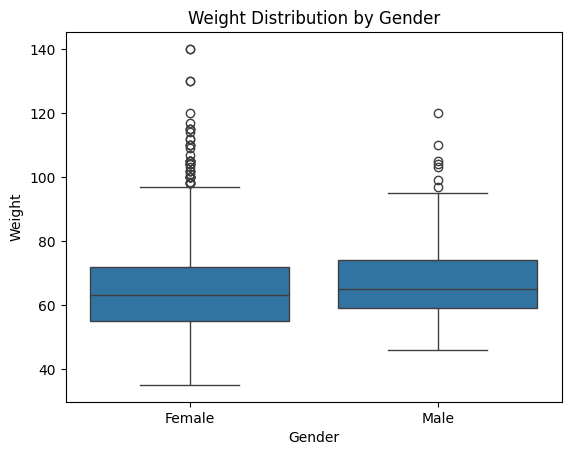

In [ ]:
sns.boxplot(x='Gender', y='Weight', data=df1)
plt.title("Weight Distribution by Gender")
plt.show()


### Average Weight & Height by Gender

In [ ]:
print(df1.groupby('Gender')[['Height', 'Weight']].mean())

            Height     Weight
Gender                       
Female  151.994557  65.357520
Male    161.216023  67.248215


### Gender Distribution per Branch

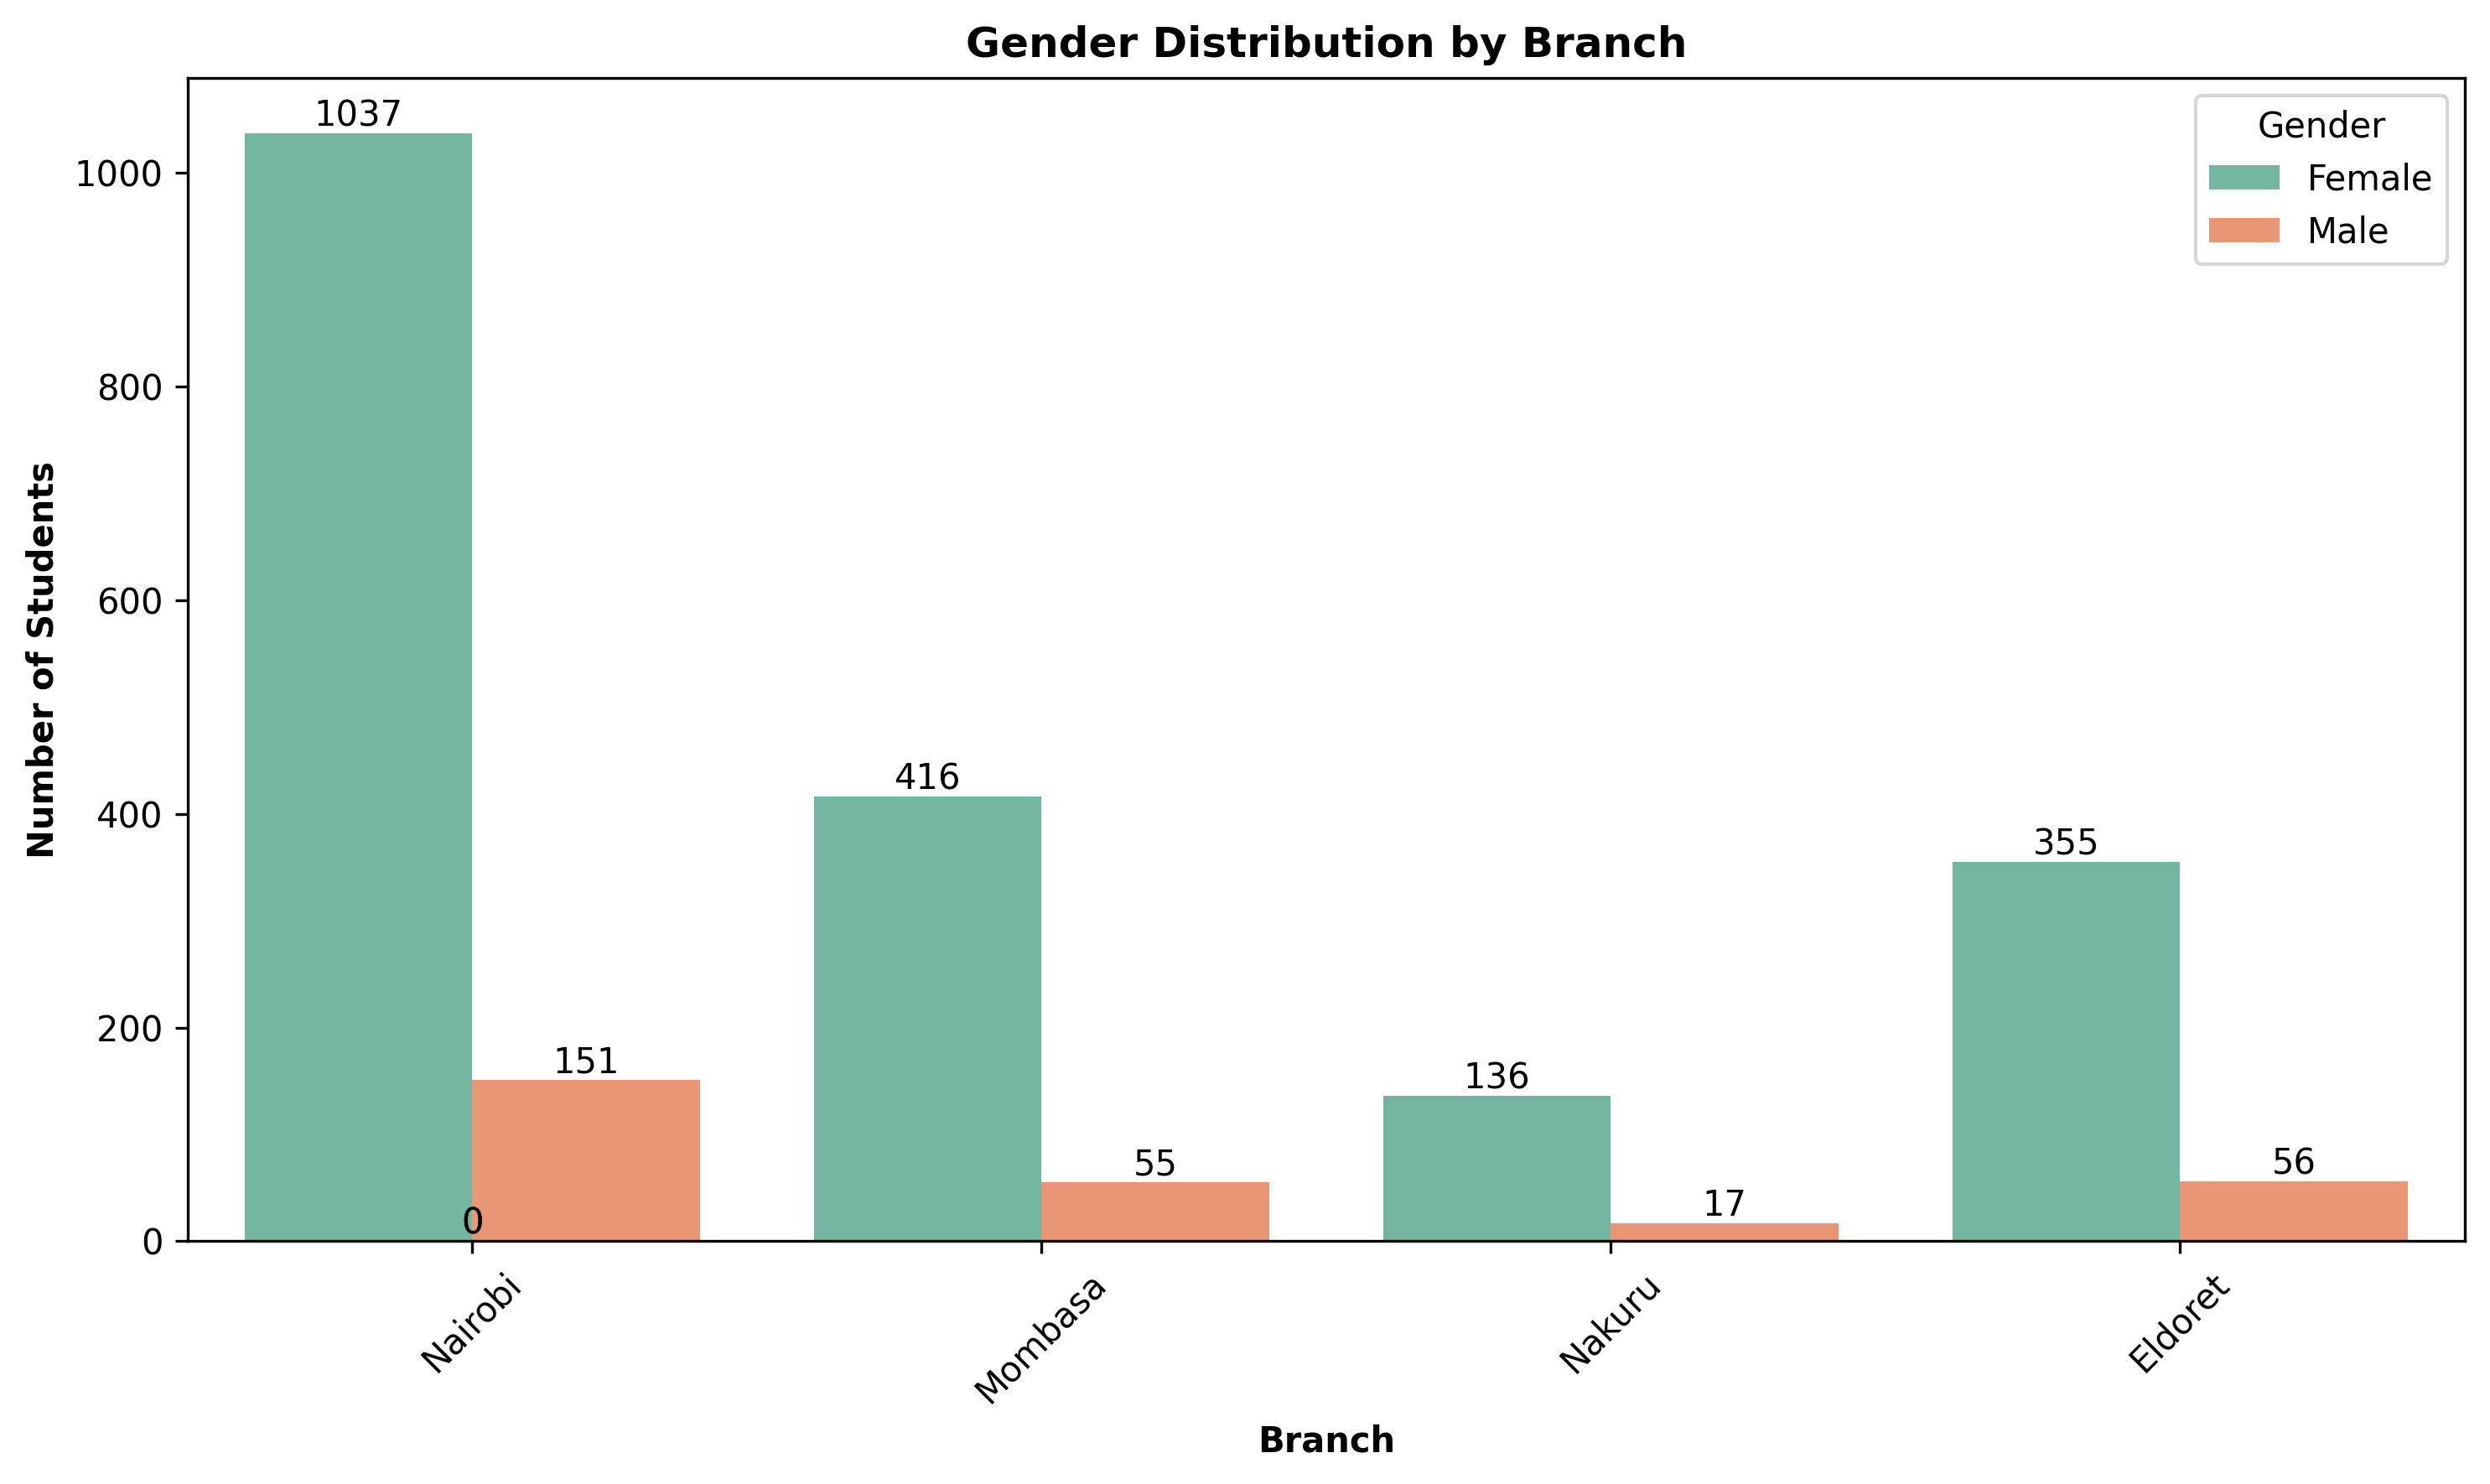

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

ax = sns.countplot(data=df1, x='Branch', hue='Gender', palette='Set2')

plt.title('Gender Distribution by Branch', fontweight='bold')
plt.xlabel('Branch', fontweight='bold')
plt.ylabel('Number of Students', fontweight='bold')

plt.xticks(rotation=45)

plt.legend(title='Gender')
plt.tight_layout()

# Add annotations
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Save as JPG
plt.savefig("gender_distribution_by_branch.jpg", dpi=300, format='jpg')

plt.show()


### Gender Distribution per Course

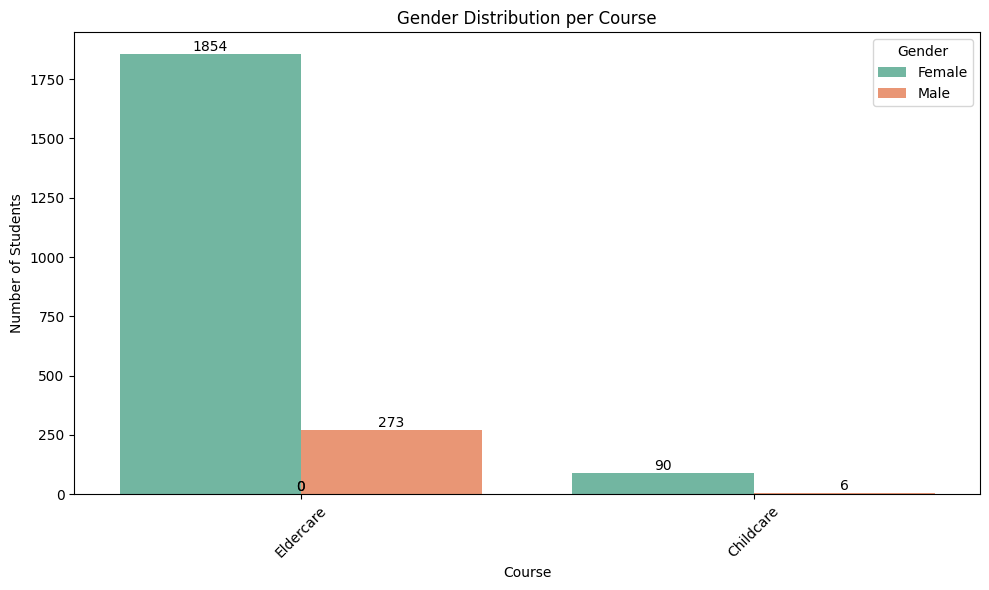

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Course', hue='Gender', palette='Set2')
plt.title('Gender Distribution per Course')
plt.xlabel('Course')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

### Age Group distribution analysis

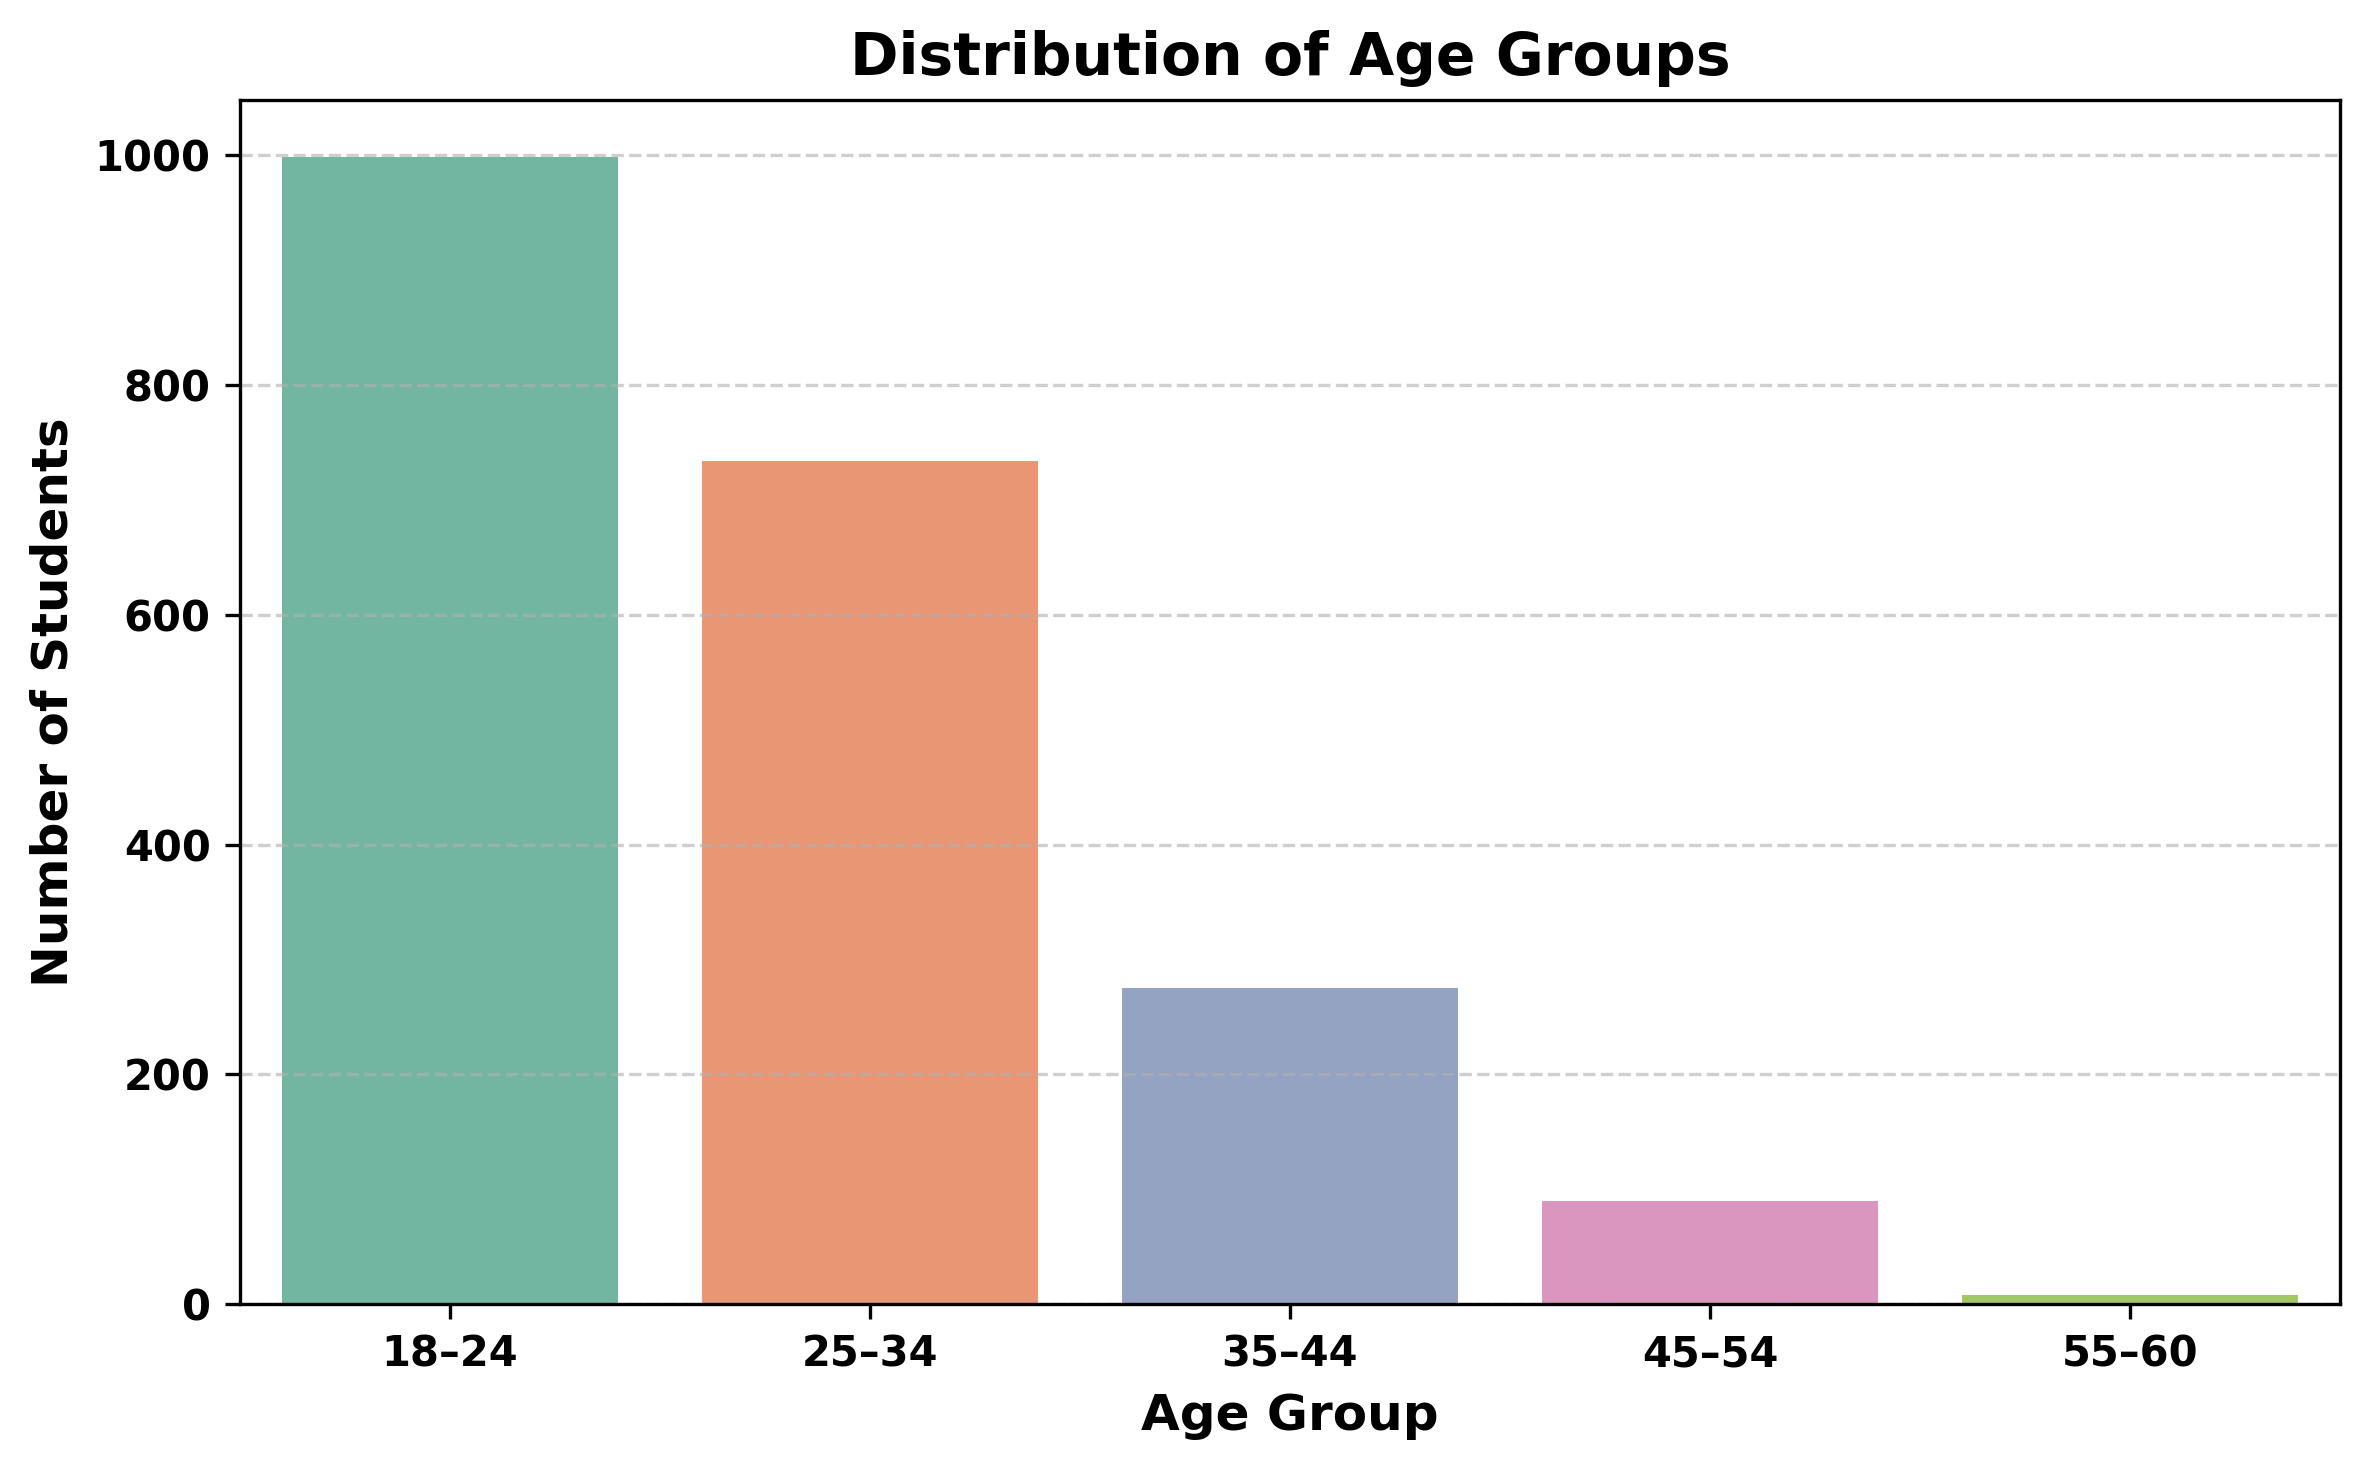

In [ ]:
plt.figure(figsize=(8, 5), dpi=300)
sns.countplot(data=df1, x='Age Group', palette='Set2', order=labels)
plt.title('Distribution of Age Groups', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12, fontweight='bold')
plt.ylabel('Number of Students', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold', rotation=0)
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('age_group_distribution.jpg', dpi=300, bbox_inches='tight', format='jpg')
plt.show()


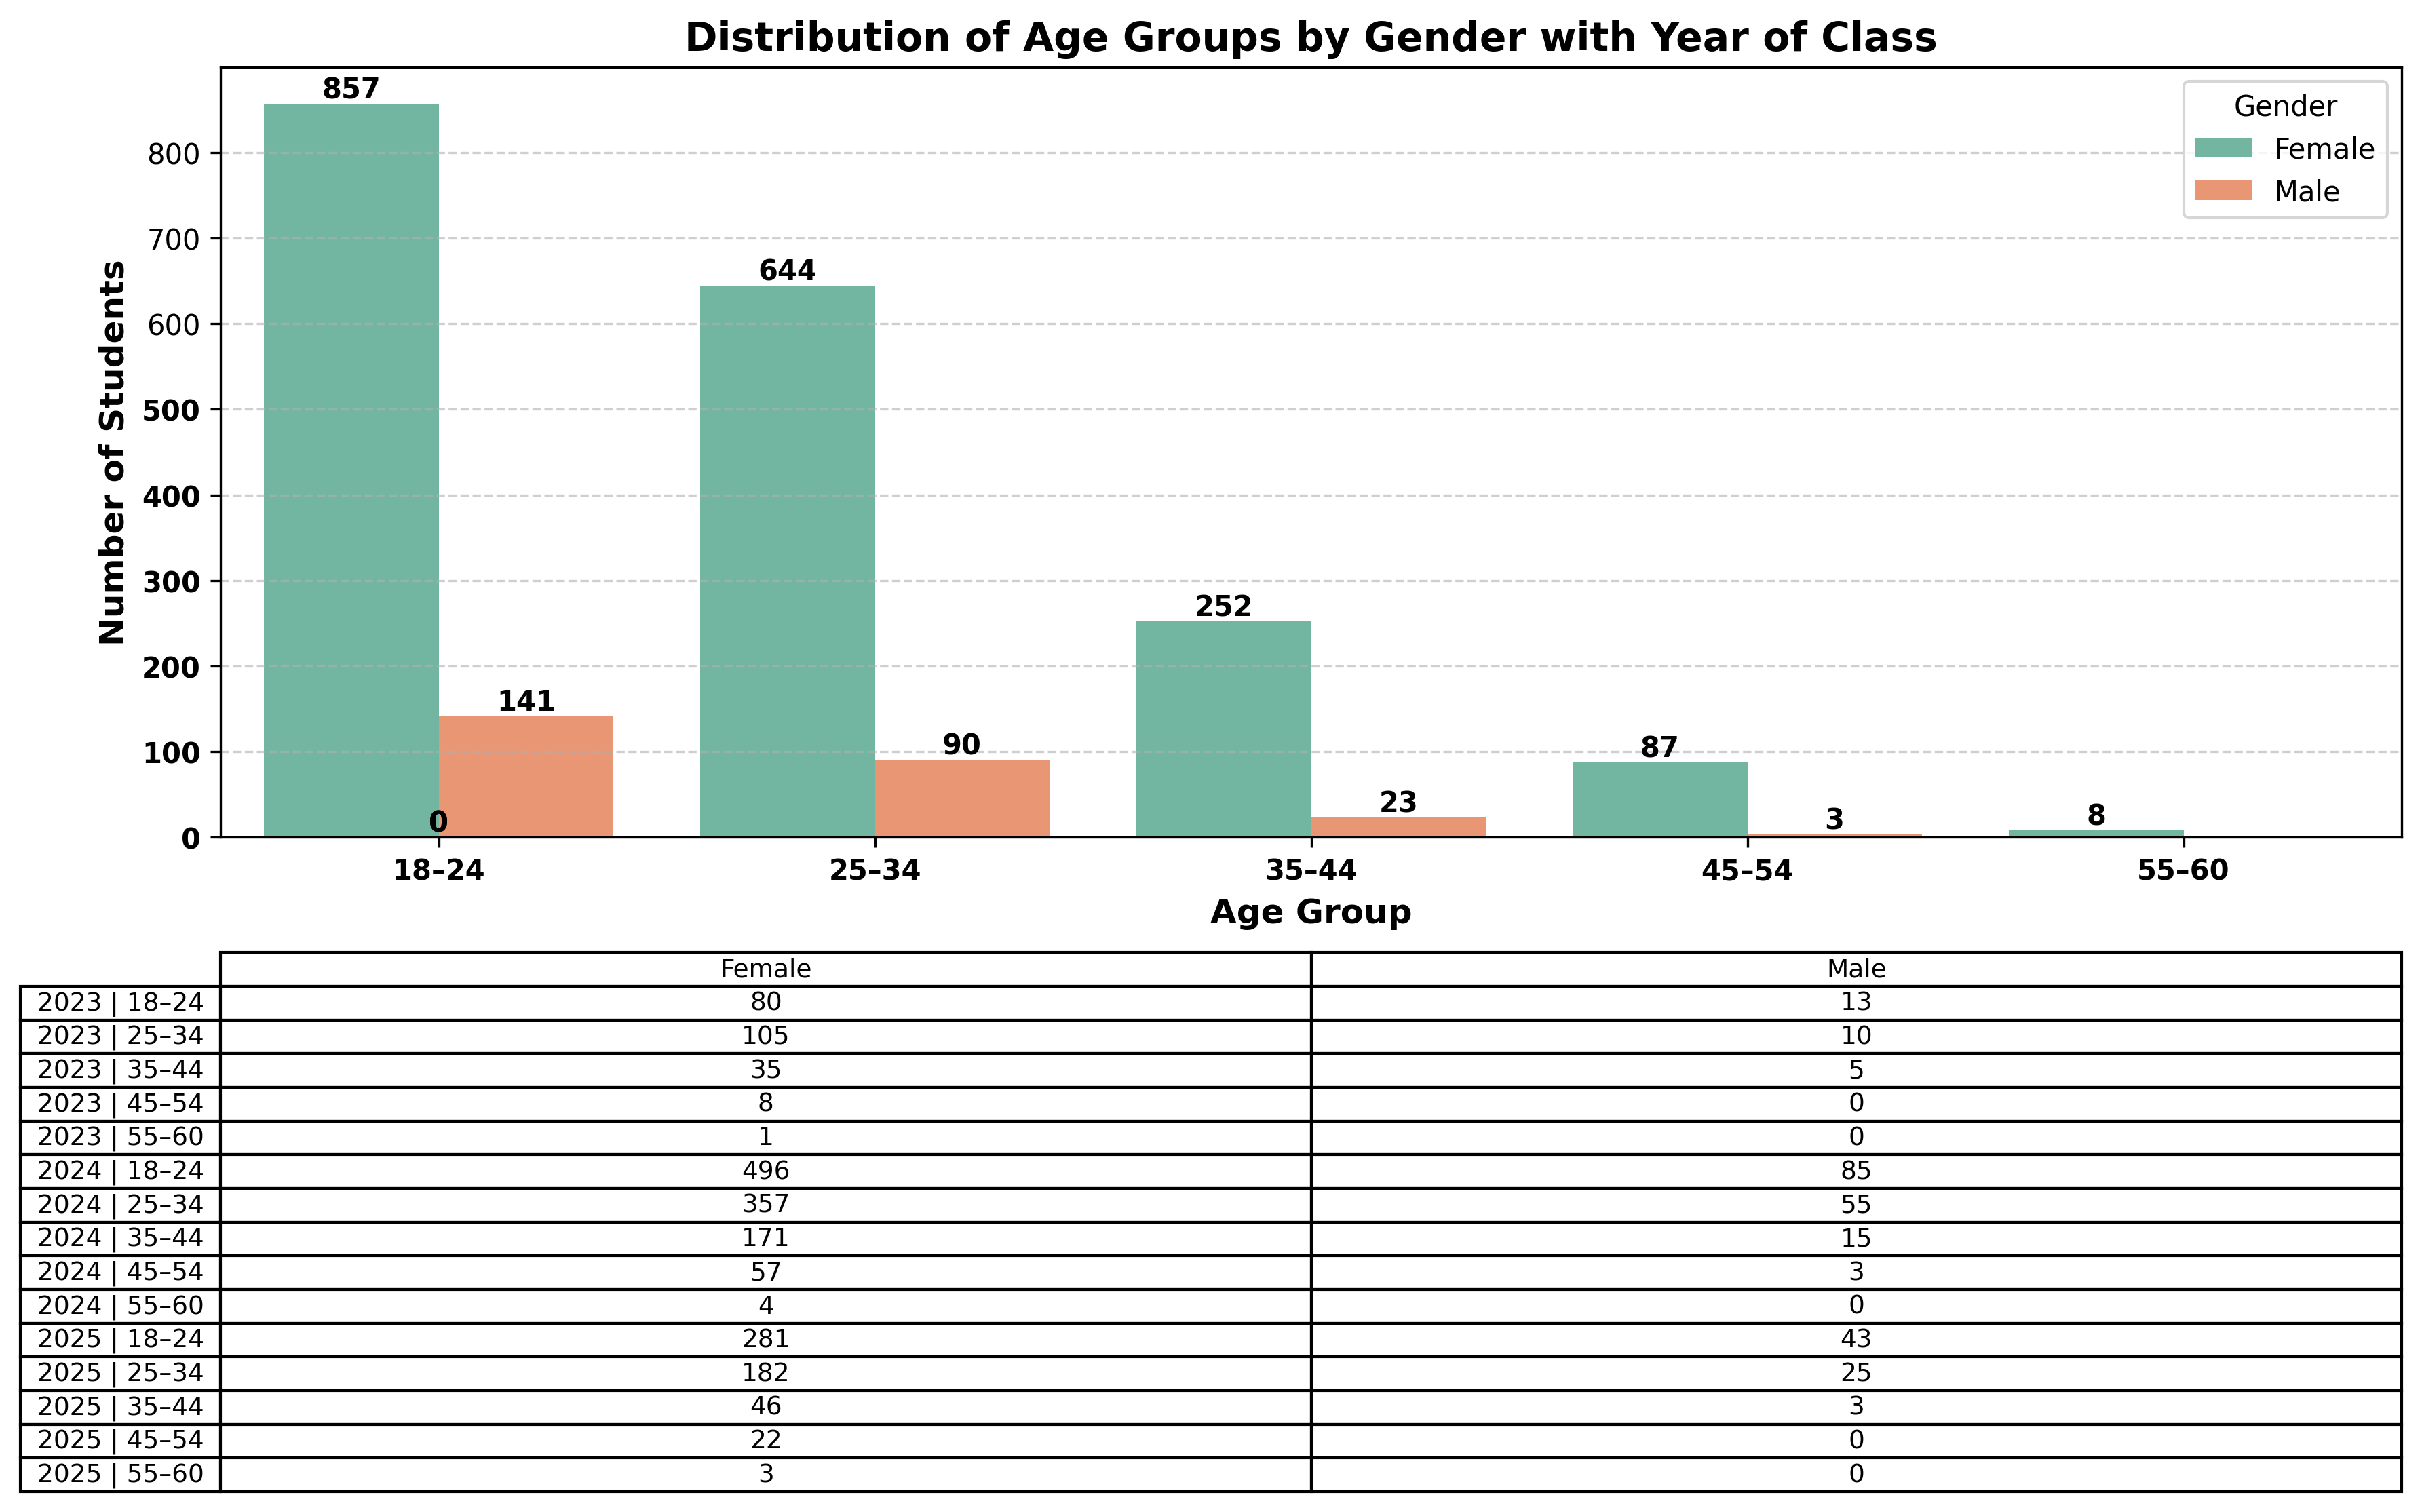

In [ ]:
plt.figure(figsize=(12, 6), dpi=300)

# Countplot
ax = sns.countplot(
    data=df1,
    x='Age Group',
    hue='Gender',
    palette='Set2',
    order=labels
)

# Add bar labels as whole numbers
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Prepare table data: counts per Age Group, Gender, Year of Class
table_data = df1.groupby(['Year of Class', 'Age Group', 'Gender']).size().unstack(fill_value=0)

table_data_reset = table_data.reset_index()
table_data_reset['Age-Year'] = (
    table_data_reset['Year of Class'].astype(str) + " | " + table_data_reset['Age Group'].astype(str)
)
table_for_table = table_data_reset[['Age-Year', 'Female', 'Male']].set_index('Age-Year')

# Increase bottom margin a lot
plt.subplots_adjust(bottom=0.55)

# Add table *far below*
table = plt.table(
    cellText=table_for_table.values,
    rowLabels=table_for_table.index,
    colLabels=table_for_table.columns,
    cellLoc='center',
    rowLoc='center',
    colLoc='center',
    loc='bottom',
    bbox=[0, -0.85, 1, 0.7]   # ↓↓↓ pushed further down
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Styling
plt.title('Distribution of Age Groups by Gender with Year of Class', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12, fontweight='bold')
plt.ylabel('Number of Students', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold', rotation=0)
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('age_group_gender_year_distribution.jpg', dpi=300, bbox_inches='tight', format='jpg')
plt.show()


### Education Level Distribution with the Age Groups

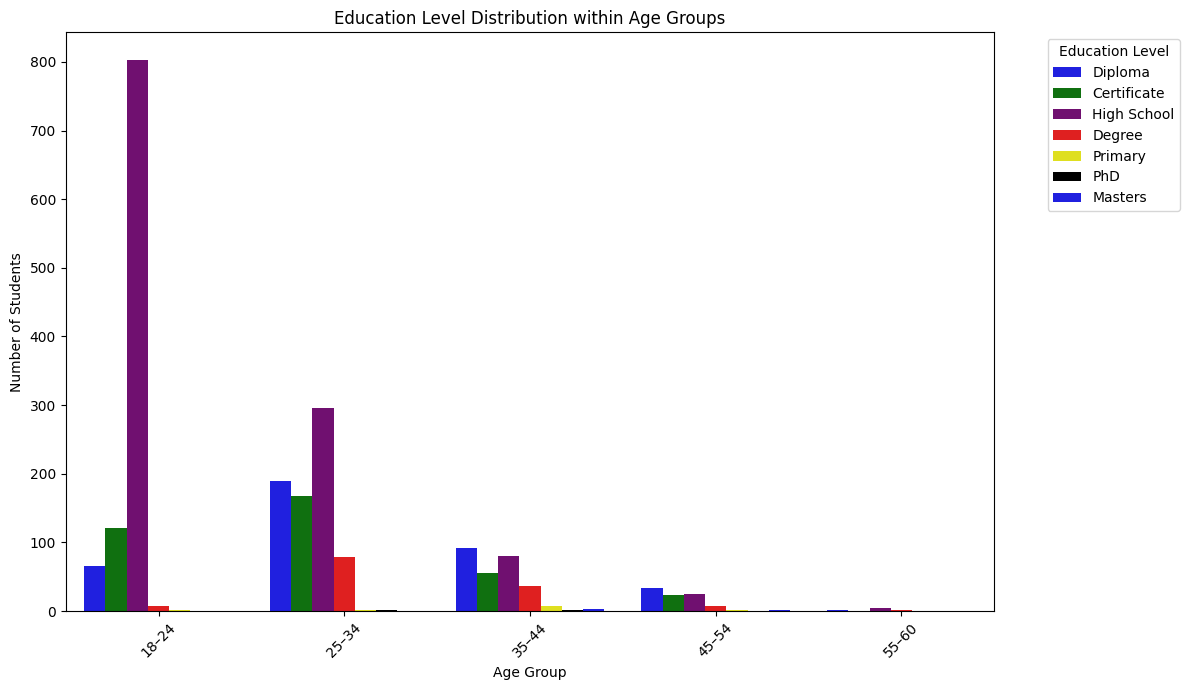

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data=df1, x='Age Group', hue='Education_Level', palette=['blue', 'green', 'purple', 'red', 'yellow', 'black'], order=labels)
plt.title('Education Level Distribution within Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Analysis of Age Group distribution by Class Start Year

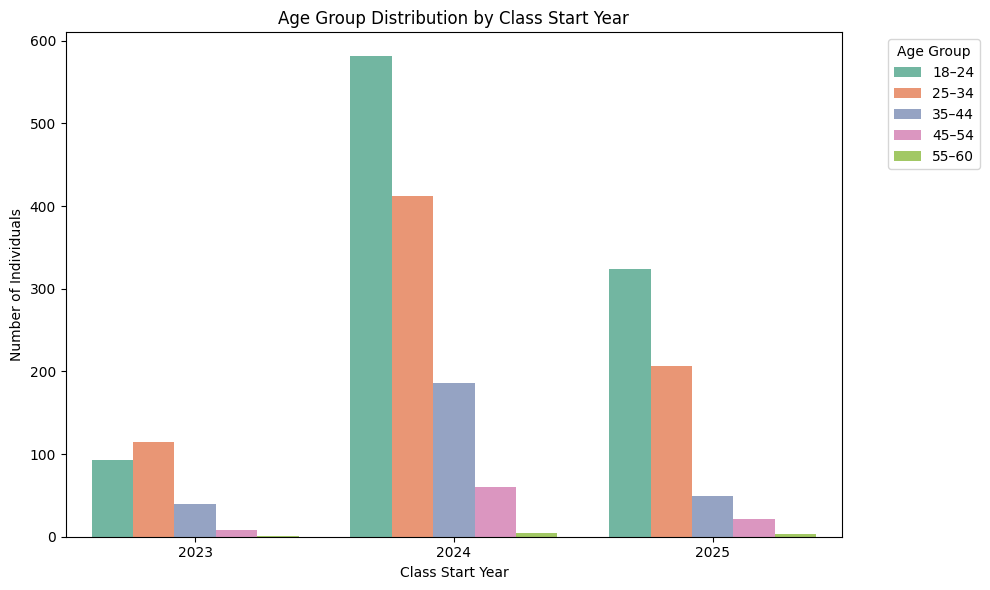

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df1, x='Year of Class', hue='Age Group', palette='Set2')
plt.title('Age Group Distribution by Class Start Year')
plt.xlabel('Class Start Year')
plt.ylabel('Number of Individuals')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

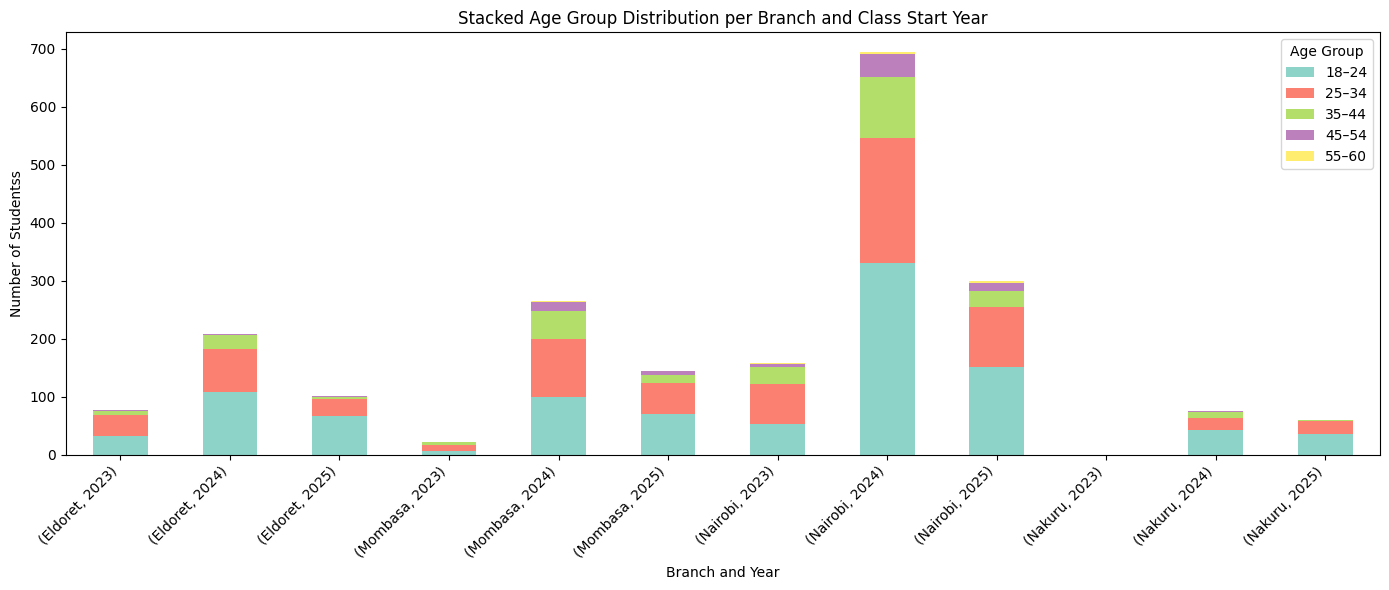

In [ ]:
grouped = df1.groupby(['Branch', 'Year of Class', 'Age Group']).size().reset_index(name='Count')
pivot_table = grouped.pivot_table(index=['Branch', 'Year of Class'], columns='Age Group', values='Count', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set3')
plt.title("Stacked Age Group Distribution per Branch and Class Start Year")
plt.xlabel("Branch and Year")
plt.ylabel("Number of Studentss")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

In [ ]:
df1.drop(columns =['Course Duration','Year of Class'], inplace =True)

### Statistical Analysis of Numerical Features

In [ ]:
summary = df1.describe(include=['int', 'float']).T
summary['skewness'] = df1[summary.index].skew()
summary['kurtosis'] = df1[summary.index].kurtosis()

summary


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Height,2375.0,153.152837,30.713666,60.0,153.166441,160.000000,166.5,550.0,0.470451,27.690154
Weight,2375.0,65.594633,12.935044,35.0,57.000000,65.000000,72.0,140.0,1.045909,2.123877
Entry Test,2375.0,86.656400,10.942460,0.0,80.000000,86.656400,95.0,100.0,-2.674561,17.209936
Theory Exam - Icare,2375.0,78.407245,10.129012,0.0,72.000000,78.449126,85.0,100.0,-2.093789,13.851234
Hospital Internship Score,2375.0,89.549706,8.468882,0.0,87.000000,90.000000,95.0,100.0,-5.714231,55.900353
Final Score,2375.0,78.915059,16.306345,0.0,78.909050,82.000000,85.0,96.0,-4.299758,18.106908
Average Attendance,2375.0,89.336977,13.568356,0.0,86.000000,91.000000,97.0,100.0,-3.541850,17.356149
Average Cats,2106.0,76.726496,9.182459,0.0,72.000000,78.000000,83.0,98.0,-1.676605,9.667736
Average Handouts,2116.0,83.006616,20.359440,0.0,81.000000,88.000000,94.0,100.0,-3.178727,10.229818
Average Practicals,2375.0,85.423158,31.784683,0.0,94.000000,98.000000,100.0,100.0,-2.261261,3.247720


In [ ]:
#df1.drop(columns=['School'], inplace=True)

### A correlation Heatmap of Numerical Features

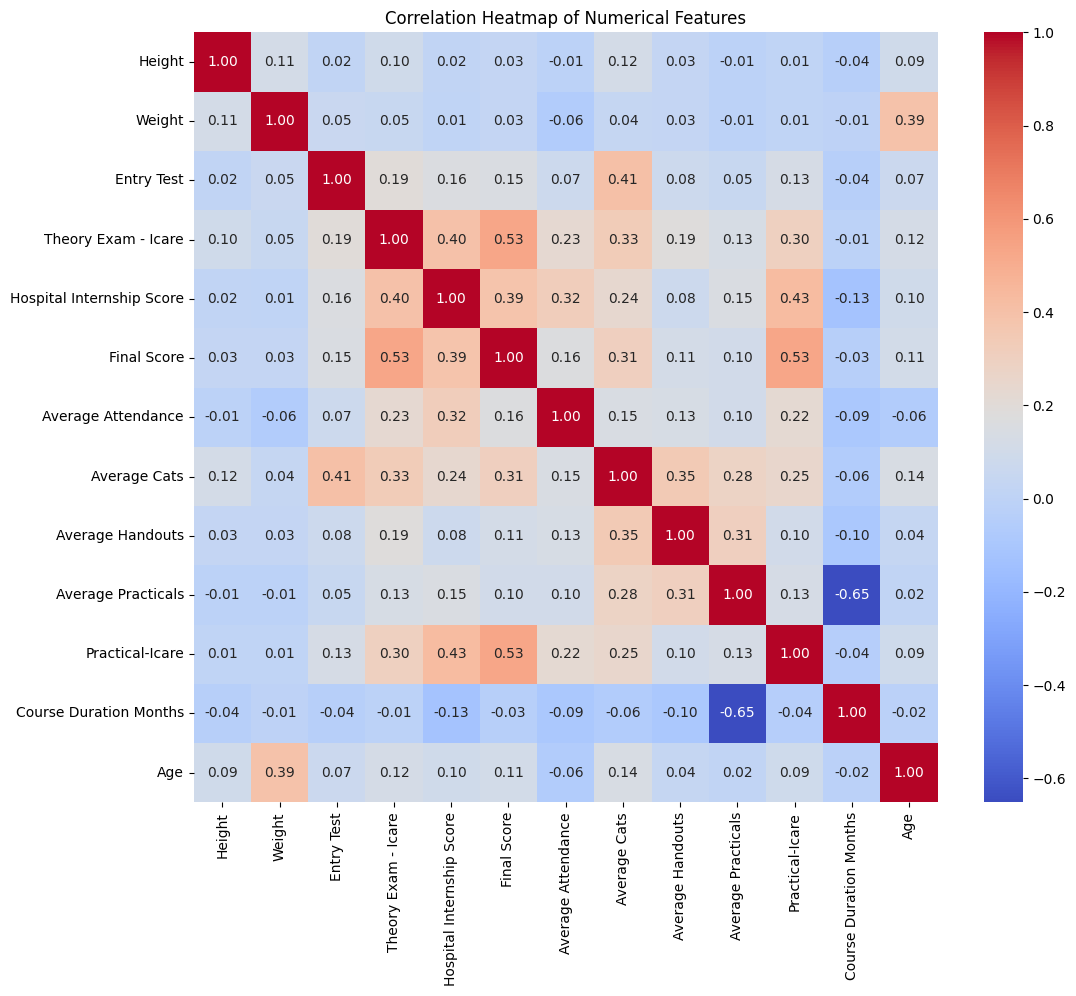

In [ ]:
numerical_cols = df1.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df1[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
df2 = df1.copy()

In [ ]:
cols = [
    'Entry Test',
    'Theory Exam - Icare',
    'Hospital Internship Score',
    'Final Score',
    'Average Attendance',
    'Average Cats',
    'Average Handouts',
    'Average Practicals',
    'Practical-Icare'
]
for c in cols:
    median_val = df2[c].median()
    df2[c] = df2[c].replace(0, median_val)


In [ ]:
transitioned = df2[df2['Transitioned_to_Caregiving'] == 'Transitioned to Care']

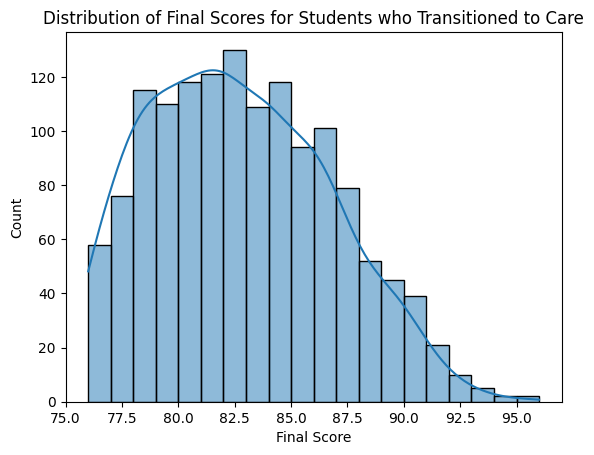

In [ ]:
sns.histplot(transitioned['Final Score'], kde=True, bins=20)
plt.title("Distribution of Final Scores for Students who Transitioned to Care")
plt.xlabel("Final Score")
plt.ylabel("Count")
plt.show()


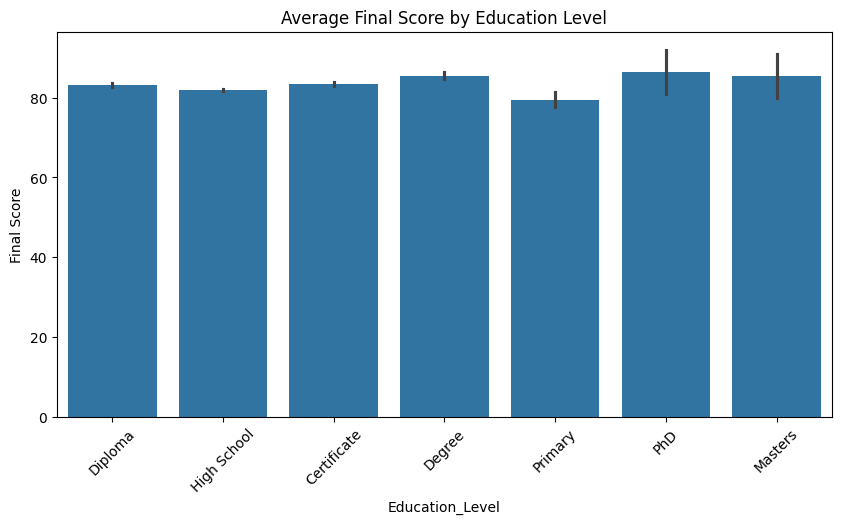

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='Education_Level', y='Final Score', data=transitioned)
plt.title("Average Final Score by Education Level")
plt.xticks(rotation=45)
plt.show()


### Check on how the students who transitioned performed

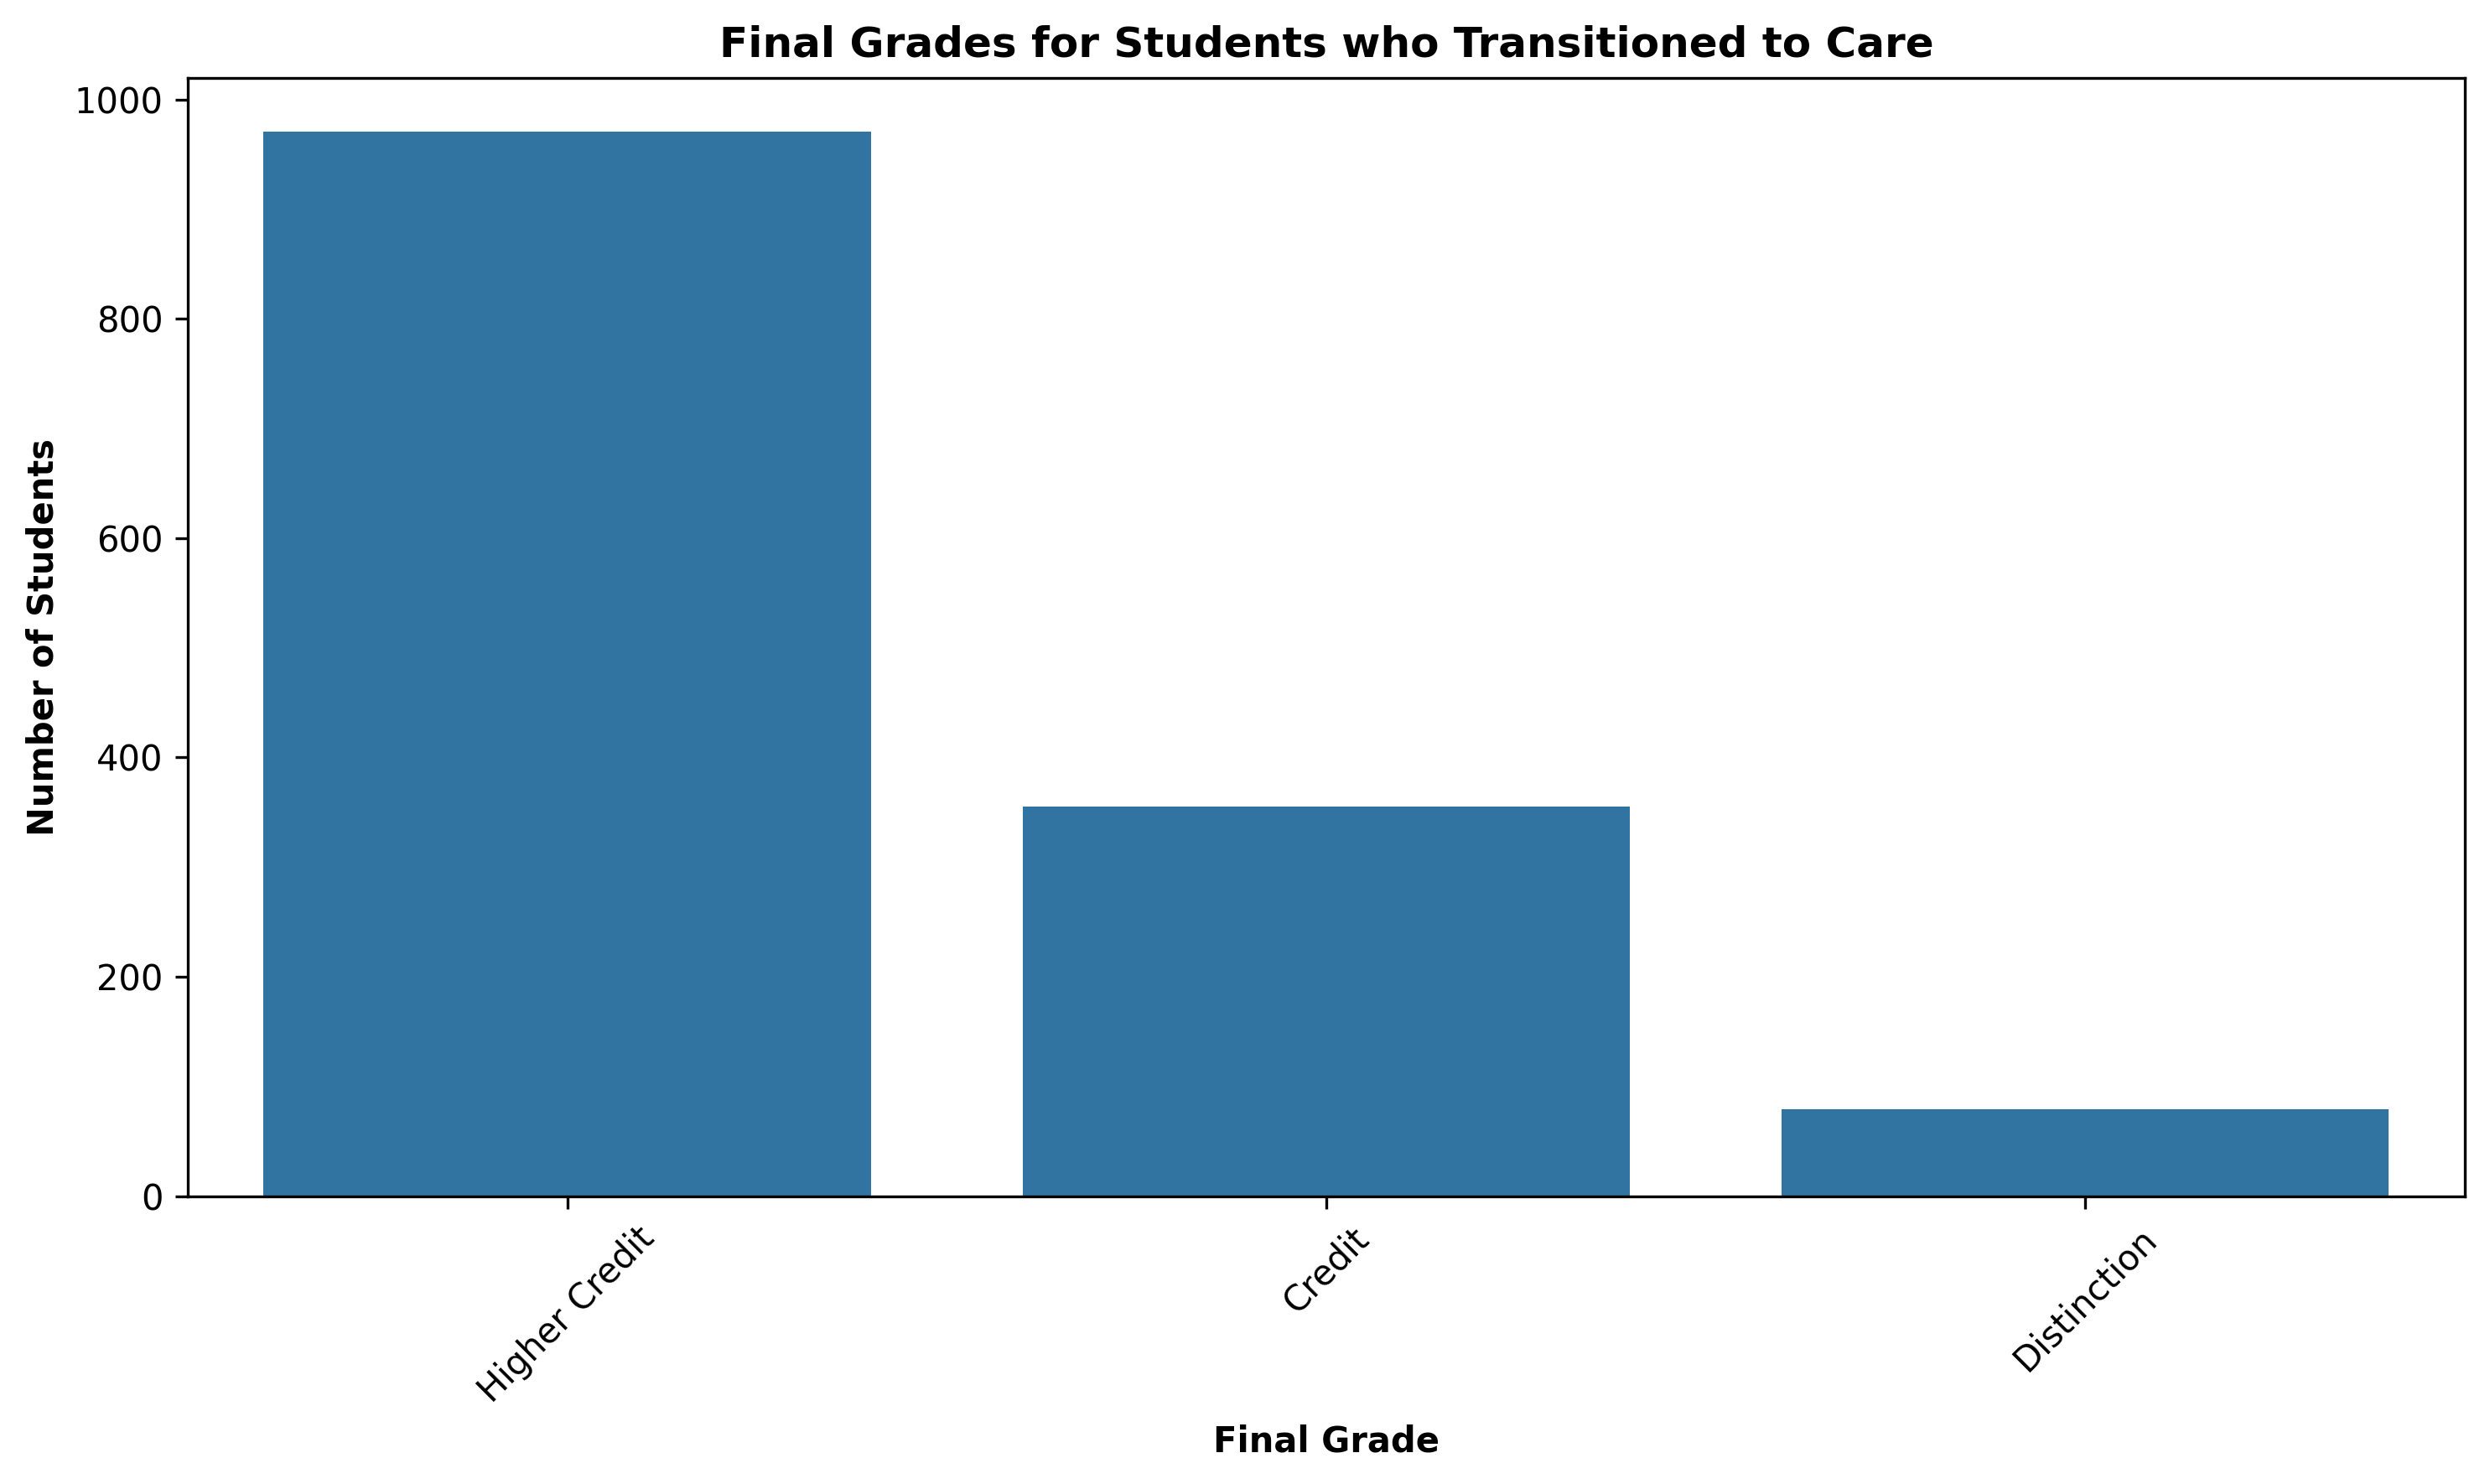

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)

ax = sns.countplot(
    x='Final Grade',
    data=transitioned,
    order=transitioned['Final Grade'].value_counts().index
)

plt.title("Final Grades for Students who Transitioned to Care", fontweight='bold')
plt.xlabel("Final Grade", fontweight='bold')
plt.ylabel("Number of Students", fontweight='bold')

plt.xticks(rotation=45)

plt.tight_layout()

# Save as JPG
plt.savefig("transitioned_final_grades.jpg", dpi=300, format='jpg')

plt.show()


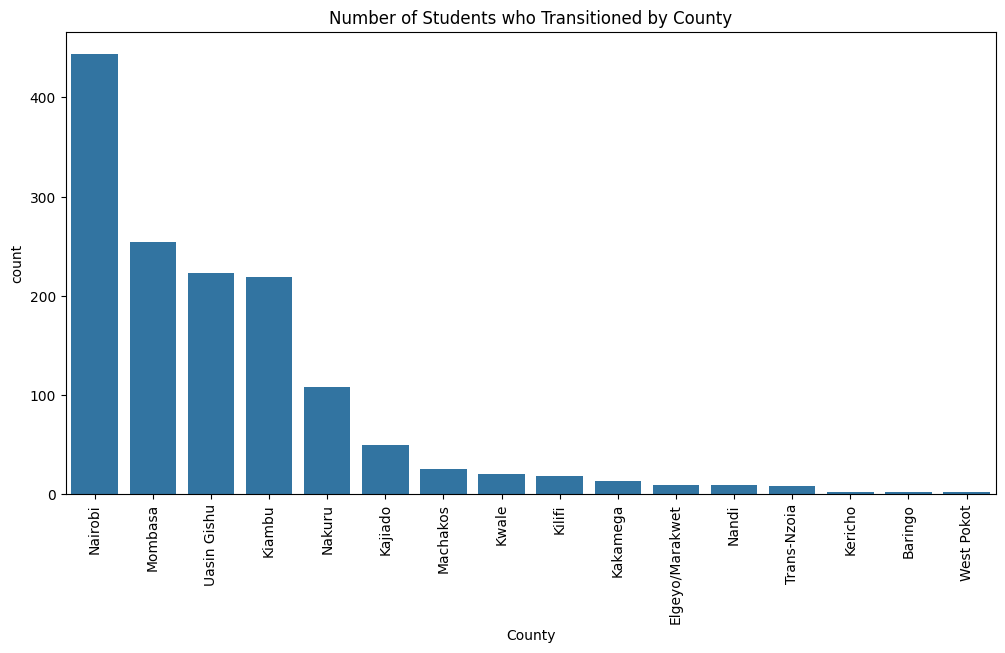

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='County', data=transitioned, order=transitioned['County'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Number of Students who Transitioned by County")
plt.show()


### Number who transitioned per Branch

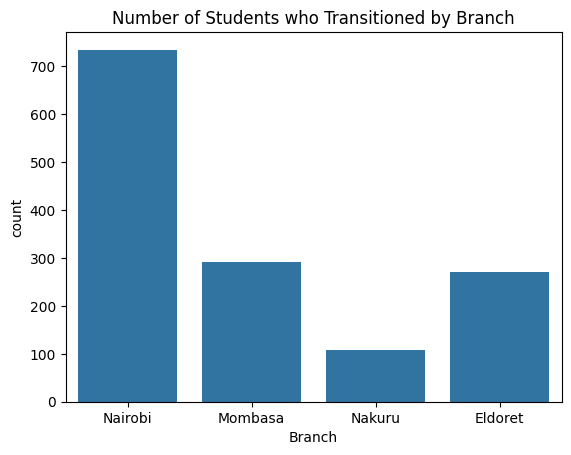

In [ ]:
sns.countplot(x='Branch', data=transitioned)
plt.title("Number of Students who Transitioned by Branch")
plt.show()


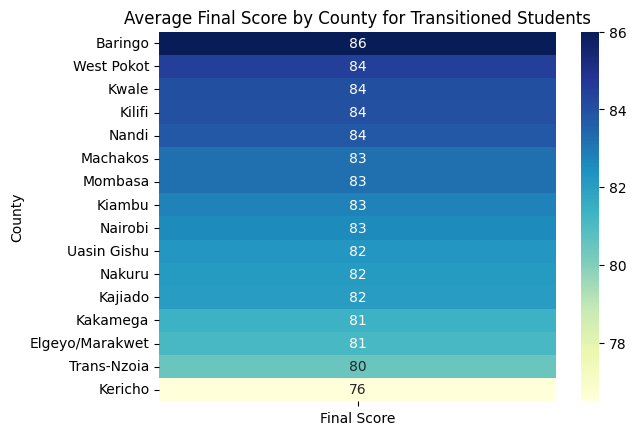

In [ ]:
pivot = transitioned.pivot_table(index='County', values='Final Score', aggfunc='mean').sort_values('Final Score', ascending=False)
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Average Final Score by County for Transitioned Students")
plt.show()


### Age group of students who transitioned

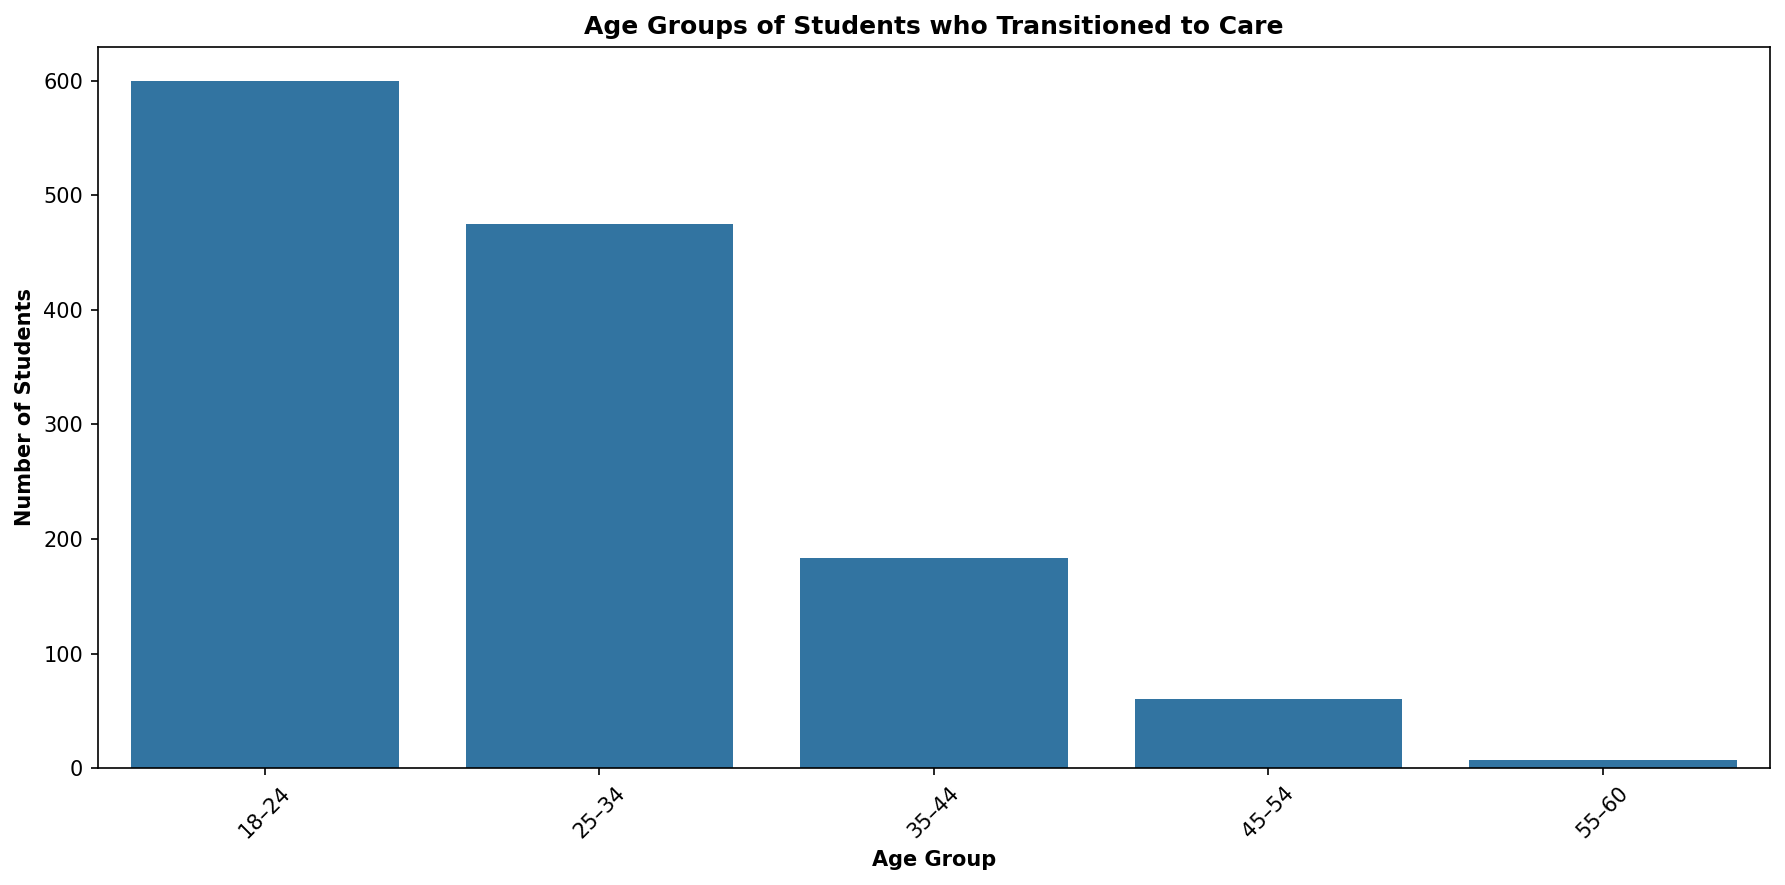

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
sns.countplot(x='Age Group', data=transitioned, order=transitioned['Age Group'].value_counts().index)
plt.title("Age Groups of Students who Transitioned to Care", fontweight='bold')
plt.xlabel("Age Group", fontweight='bold')
plt.ylabel("Number of Students", fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Gender Comparison

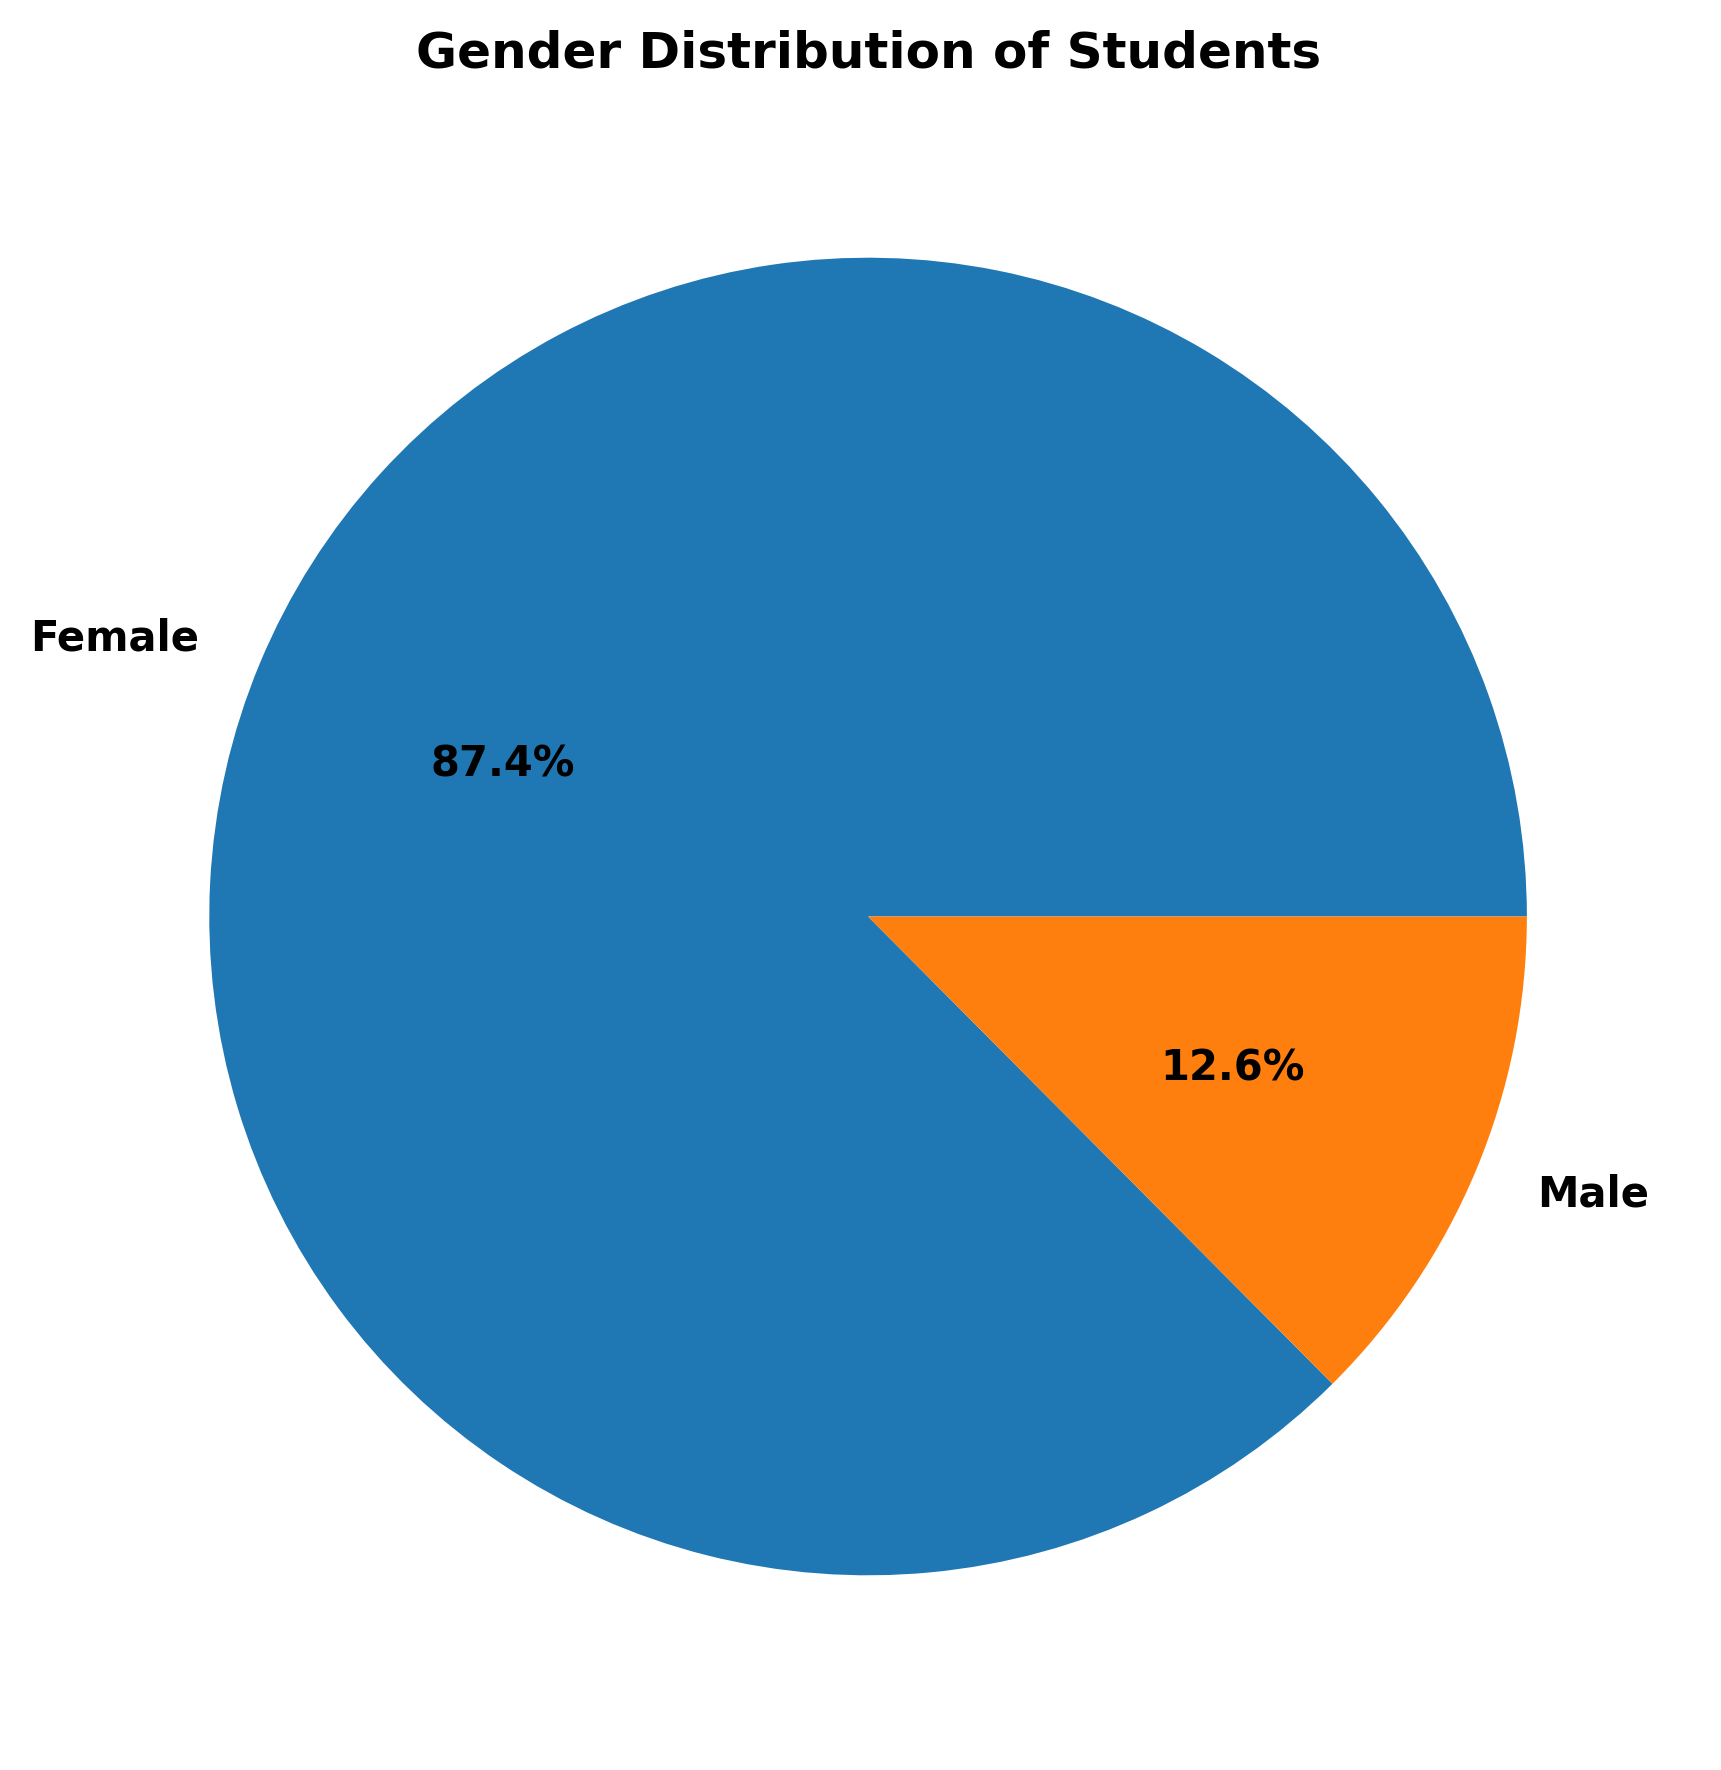

In [ ]:
plt.figure(figsize=(6, 6), dpi=300)
gender_counts = df2['Gender'].value_counts()

plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    textprops={'fontweight': 'bold'}  # Bold labels
)

plt.title("Gender Distribution of Students", fontweight='bold')

plt.tight_layout()
plt.savefig("gender_distribution.jpg", format="jpg", dpi=300)

plt.show()

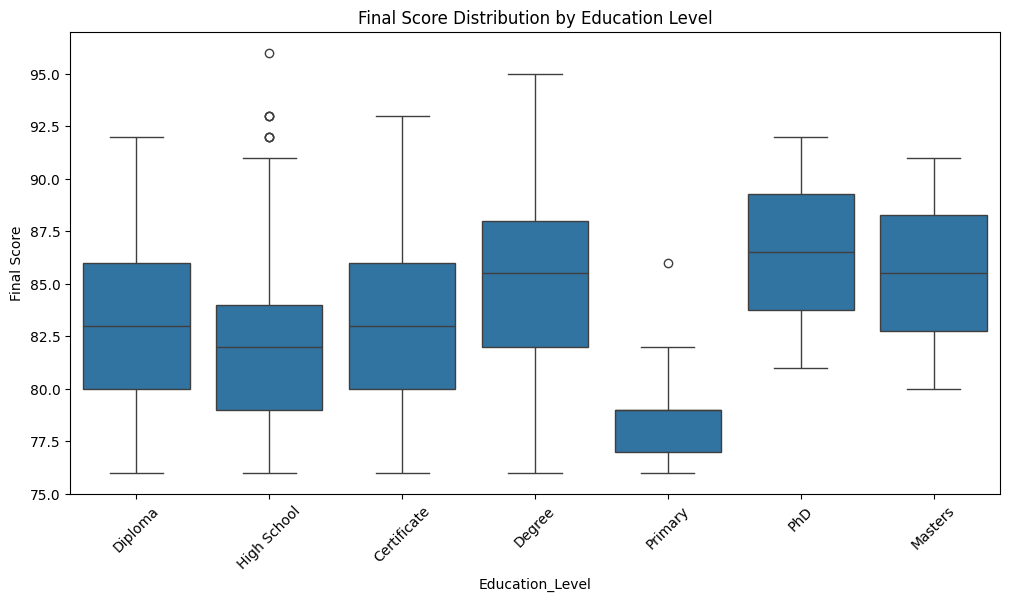

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Education_Level', y='Final Score', data=transitioned)
plt.xticks(rotation=45)
plt.title("Final Score Distribution by Education Level")
plt.show()


In [ ]:
transitioned['Entry Test'].describe()

,Entry Test
count,1405.000000
mean,87.436623
std,9.078013
min,50.000000
25%,80.000000
50%,88.000000
75%,95.000000
max,100.000000


In [ ]:
numeric_cols = ['Height', 'Weight', 'Final Score', 'Theory Exam - Icare',
                'Practical-Icare', 'Hospital Internship Score',
                'Average Attendance', 'Average Cats', 'Average Handouts',
                'Average Practicals', 'Course Duration Months', 'Age']

desc_stats = transitioned[numeric_cols].describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats


,count,mean,std,min,25%,50%,75%,max,range
Height,1405.0,153.557512,32.901185,60.0,153.0,160.0,167.0,550.0,490.0
Weight,1405.0,65.850660,13.179260,35.0,57.0,64.0,72.0,140.0,105.0
Final Score,1405.0,82.632481,3.991905,76.0,79.0,82.0,86.0,96.0,20.0
Theory Exam - Icare,1405.0,78.911279,8.405790,56.0,72.0,80.0,85.0,98.0,42.0
Practical-Icare,1405.0,77.439488,6.262410,60.0,73.0,78.0,83.0,95.0,35.0
Hospital Internship Score,1405.0,90.751268,5.510536,64.0,88.0,92.0,95.0,100.0,36.0
Average Attendance,1405.0,88.994826,13.473154,9.0,86.0,91.0,97.0,100.0,91.0
Average Cats,1297.0,77.845027,7.897679,30.0,73.0,78.0,84.0,98.0,68.0
Average Handouts,1306.0,87.604135,8.017239,41.0,83.0,89.0,94.0,100.0,59.0
Average Practicals,1405.0,96.923843,4.776847,61.0,97.0,98.0,100.0,100.0,39.0


### Measures of Central Tendency & Dispersion

In [ ]:
from scipy import stats
# Create an empty list to store the statistics
summary_data = []

for col in numeric_cols:
    mean_val = transitioned[col].mean()
    median_val = transitioned[col].median()
    mode_val = transitioned[col].mode()[0] if not transitioned[col].mode().empty else None
    std_val = transitioned[col].std()
    var_val = transitioned[col].var()
    skew_val = transitioned[col].skew()
    kurt_val = transitioned[col].kurtosis()

    summary_data.append({
        'Metric': col,
        'Mean': round(mean_val, 2),
        'Median': round(median_val, 2),
        'Mode': round(mode_val, 2) if mode_val is not None else None,
        'Std Dev': round(std_val, 2),
        'Variance': round(var_val, 2),
        'Skewness': round(skew_val, 2),
        'Kurtosis': round(kurt_val, 2)
    })

# Convert to DataFrame
summary_table = pd.DataFrame(summary_data)

# Display neatly
print("\nStatistical Summary for Students Who Transitioned to Care:\n")
display(summary_table)



Statistical Summary for Students Who Transitioned to Care:



,Metric,Mean,Median,Mode,Std Dev,Variance,Skewness,Kurtosis
0,Height,153.56,160.0,160.0,32.90,1082.49,1.49,33.79
1,Weight,65.85,64.0,60.0,13.18,173.69,1.04,2.18
2,Final Score,82.63,82.0,82.0,3.99,15.94,0.35,-0.56
3,Theory Exam - Icare,78.91,80.0,84.0,8.41,70.66,-0.11,-0.63
4,Practical-Icare,77.44,78.0,78.0,6.26,39.22,-0.18,-0.47
5,Hospital Internship Score,90.75,92.0,95.0,5.51,30.37,-0.95,1.00
6,Average Attendance,88.99,91.0,97.0,13.47,181.53,-3.12,13.40
7,Average Cats,77.85,78.0,78.0,7.90,62.37,-0.61,1.24
8,Average Handouts,87.60,89.0,88.0,8.02,64.28,-1.14,2.23
9,Average Practicals,96.92,98.0,100.0,4.78,22.82,-3.73,19.20


### Categorical columns Frequency Distribution

In [ ]:
categorical_cols = ['Gender', 'County', 'Sub_County', 'Location',
                    'Education_Level', 'Primary/Highschool_Grade',
                    'Course', 'Branch', 'Age Group', 'Final Grade',
                    'Hospital Internship Attended']

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(transitioned[col].value_counts())
    print(transitioned[col].value_counts(normalize=True))  # proportions



Column: Gender
Gender
Female    1224
Male       181
Name: count, dtype: int64
Gender
Female    0.871174
Male      0.128826
Name: proportion, dtype: float64

Column: County
County
Nairobi            444
Mombasa            254
Uasin Gishu        223
Kiambu             219
Nakuru             108
Kajiado             49
Machakos            25
Kwale               20
Kilifi              18
Kakamega            13
Elgeyo/Marakwet      9
Nandi                9
Trans-Nzoia          8
Kericho              2
Baringo              2
West Pokot           2
Name: count, dtype: int64
County
Nairobi            0.316014
Mombasa            0.180783
Uasin Gishu        0.158719
Kiambu             0.155872
Nakuru             0.076868
Kajiado            0.034875
Machakos           0.017794
Kwale              0.014235
Kilifi             0.012811
Kakamega           0.009253
Elgeyo/Marakwet    0.006406
Nandi              0.006406
Trans-Nzoia        0.005694
Kericho            0.001423
Baringo            0.001423

### Cross-tabulations for relationships between categorical variables and performance

In [ ]:
# Average final score by education level
pd.crosstab(transitioned['Education_Level'], columns='Average Final Score',
            values=transitioned['Final Score'], aggfunc='mean')

# Average score by county
pd.crosstab(transitioned['County'], columns='Average Final Score',
            values=transitioned['Final Score'], aggfunc='mean')


col_0,Average Final Score
County,
Baringo,86.000000
Elgeyo/Marakwet,81.111111
Kajiado,82.061224
Kakamega,81.384615
Kericho,76.500000
Kiambu,82.802822
Kilifi,84.000000
Kwale,84.050000
Machakos,83.200000


### Compare Final Score Between Transitioned and Non-Transitioned Students

In [ ]:
transitioned_scores = df[df['Transitioned_to_Caregiving'] == 'Transitioned to Care']['Final Score']
non_transitioned_scores = df[df['Transitioned_to_Caregiving'] == "Didn't Transition"]['Final Score']
t_stat, p_val = stats.ttest_ind(transitioned_scores, non_transitioned_scores, equal_var=False)

print("Comparison: Transitioned vs. Didn't Transition")
print(f"T-statistic = {t_stat:.2f}")
print(f"P-value = {p_val:.4f}")

# Interpret
if p_val < 0.05:
    print(" Statistically significant difference in mean Final Scores.")
else:
    print(" No statistically significant difference in mean Final Scores.")


Comparison: Transitioned vs. Didn't Transition
T-statistic = 11.67
P-value = 0.0000
 Statistically significant difference in mean Final Scores.


### **Interpretation**

*   The t-test (t = 11.67, p < 0.001) indicates that the mean Final Scores of the two groups are not equal, with the Transitioned group performing differently compared to the Did Not Transition group. Because the p-value is effectively zero, we reject the null hypothesis and conclude that the observed difference is highly unlikely to be due to chance.



### Chi-square test for independence between categorical variables:

In [ ]:
transitioned = df[df['Transitioned_to_Caregiving'] == 'Transitioned to Care']
non_transitioned = df[df['Transitioned_to_Caregiving'] == "Didn't Transition"]

#  Chi-square test WITHIN each group
print("\nChi-Square Test WITHIN Transitioned Group")
contingency_tr = pd.crosstab(transitioned['Education_Level'], transitioned['Final Grade'])
chi2_tr, p_tr, dof_tr, expected_tr = stats.chi2_contingency(contingency_tr)

print("Chi-square:", round(chi2_tr, 2))
print("p-value:", round(p_tr, 4))
print("Degrees of freedom:", dof_tr)

print("\n Chi-Square Test WITHIN Non-Transitioned Group")
contingency_non = pd.crosstab(non_transitioned['Education_Level'], non_transitioned['Final Grade'])
chi2_non, p_non, dof_non, expected_non = stats.chi2_contingency(contingency_non)

print("Chi-square:", round(chi2_non, 2))
print("p-value:", round(p_non, 4))
print("Degrees of freedom:", dof_non)




Chi-Square Test WITHIN Transitioned Group
Chi-square: 90.25
p-value: 0.0
Degrees of freedom: 12

 Chi-Square Test WITHIN Non-Transitioned Group
Chi-square: 77.54
p-value: 0.0
Degrees of freedom: 20


### **Interpretation**


*   This result indicates a strong and statistically significant association between Education Level and Final Grade among individuals who transitioned to caregiving.
*   The p-value of 0.000 suggests that the pattern of Final Grades differs significantly across education levels.
Therefore, education level meaningfully influences academic outcomes for the transitioned group.



In [ ]:
df2.drop(columns=['Age Group','Class ID', 'School'], inplace=True)

### Identify outliers using IQR Method.

Outliers in Height:
6       130.0
21       60.0
34       60.0
38       60.0
39       60.0
        ...  
2200    187.0
2209    130.0
2222    110.0
2234    110.0
2237     60.0
Name: Height, Length: 341, dtype: float64


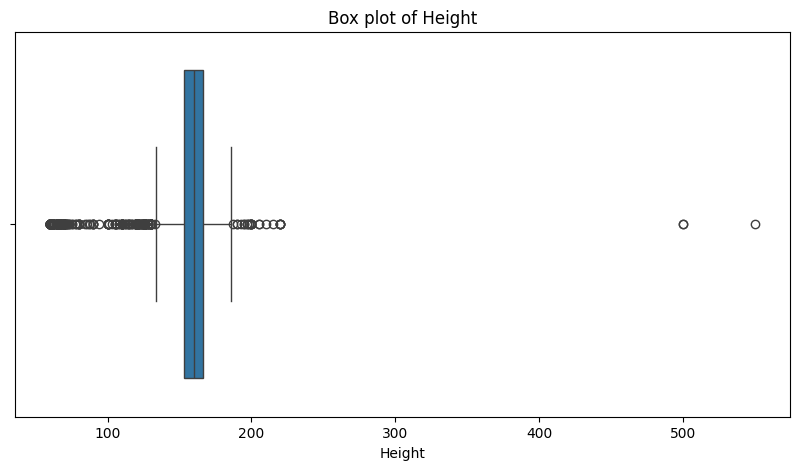

Outliers in Weight:
24      103.0
59       95.0
89      100.0
161      97.0
189      97.0
        ...  
2098    105.0
2113     95.0
2145     95.0
2204    140.0
2238    107.0
Name: Weight, Length: 73, dtype: float64


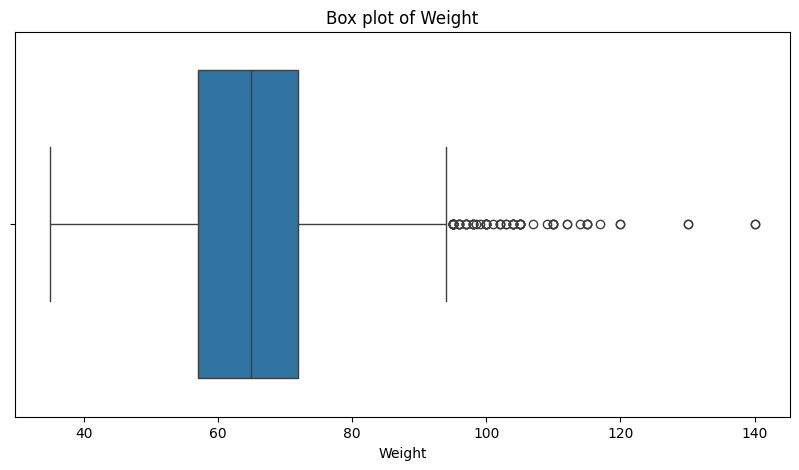

Outliers in Entry Test:
267     55.0
680     57.0
770     55.0
867     52.0
1217    50.0
1403    55.0
1508    45.0
1538    54.0
1561    42.0
1571    51.0
1591    54.0
1705    50.0
1850    55.0
1989    50.0
2141    55.0
2147    55.0
Name: Entry Test, dtype: float64


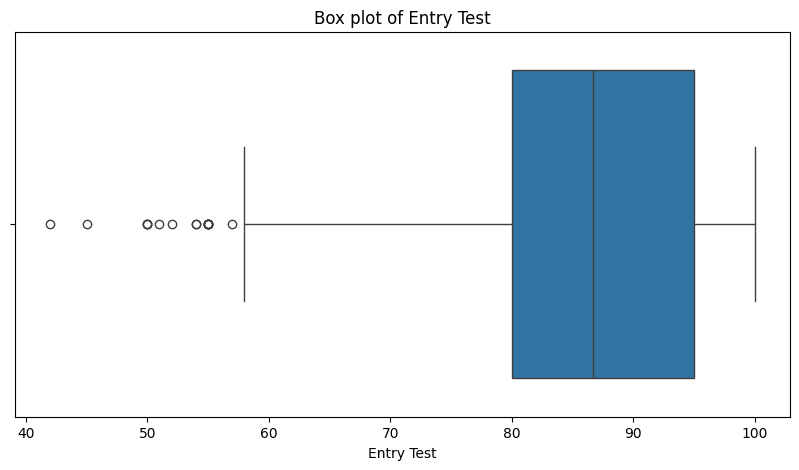

Outliers in Theory Exam - Icare:
317     48.0
379     54.0
560     56.0
585     56.0
786     54.0
851     56.0
906     54.0
931     46.0
978     42.0
992     50.0
995     56.0
997     50.0
1028    56.0
1041    52.0
1044    52.0
1054    54.0
1057    54.0
1103    42.0
1321    54.0
1323    56.0
1500    52.0
1583    56.0
1671    54.0
1727    50.0
1947    54.0
1992    56.0
2241    54.0
Name: Theory Exam - Icare, dtype: float64


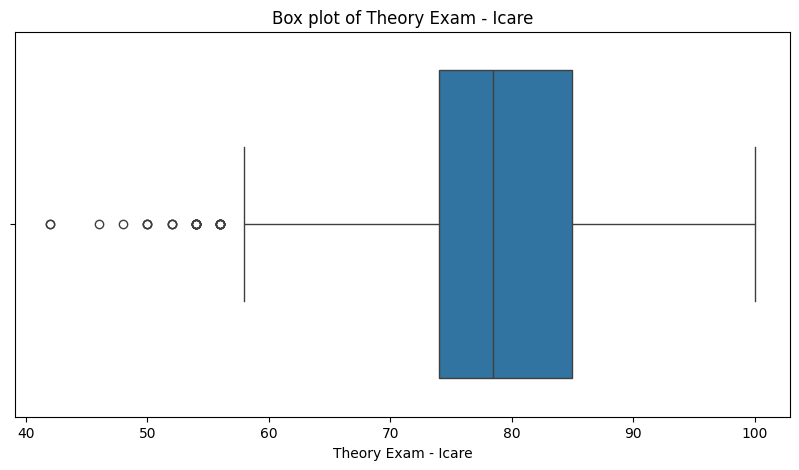

Outliers in Hospital Internship Score:
115     71.0
128     70.0
263     74.0
330     73.0
371     71.0
438     73.0
490     74.0
593     70.0
597     70.0
617     70.0
621     70.0
624     70.0
678     72.0
679     72.0
705     72.0
719     74.0
785     72.0
845     72.0
912     74.0
983     70.0
1042    73.0
1061    73.0
1124    70.0
1174    74.0
1177    72.0
1262    74.0
1313    72.0
1340    66.0
1514    72.0
1592    70.0
1642    70.0
1645    73.0
1701    72.0
1751    72.0
1787    72.0
1980    70.0
2008    70.0
2081    70.0
2106    74.0
2114    72.0
2117    68.0
2119    64.0
2146    71.0
2156    70.0
2170    70.0
2181    72.0
2233    70.0
Name: Hospital Internship Score, dtype: float64


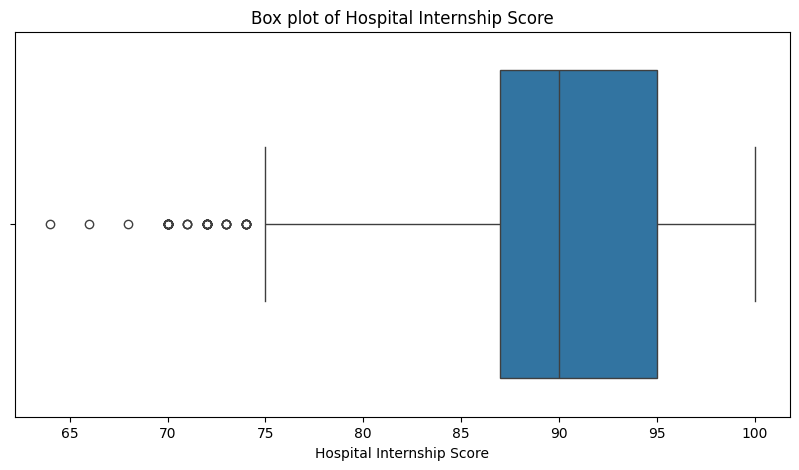

Outliers in Final Score:
2000    95.0
2053    96.0
2091    95.0
Name: Final Score, dtype: float64


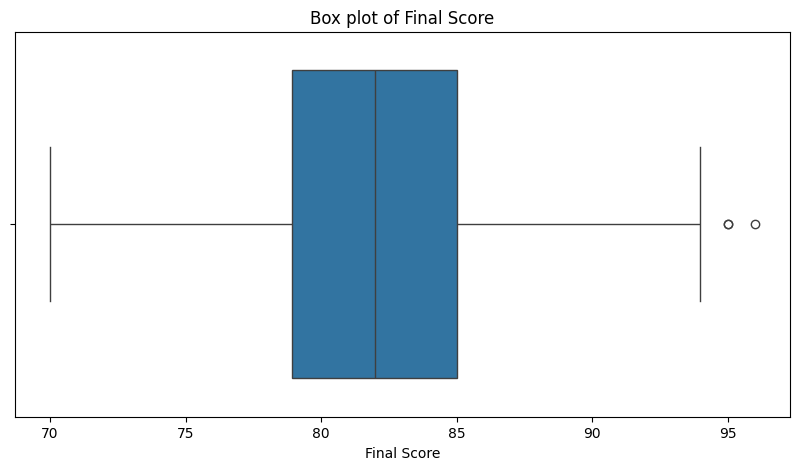

Outliers in Average Attendance:
0       43.0
6       60.0
66      66.0
77      63.0
78      60.0
        ... 
2194    69.0
2224    57.0
2227    57.0
2232    34.0
2234    54.0
Name: Average Attendance, Length: 122, dtype: float64


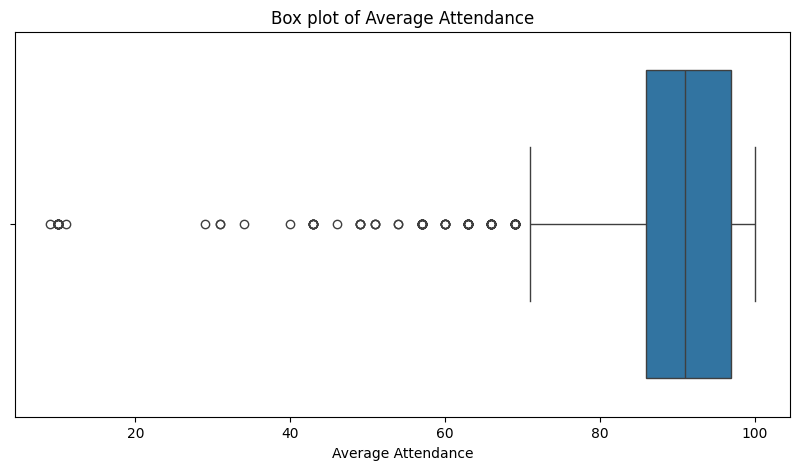

Outliers in Average Cats:
9       48.0
160     49.0
342     55.0
458     54.0
470     53.0
545     55.0
566     51.0
587     54.0
594     50.0
615     54.0
617     33.0
621     51.0
623     52.0
740     50.0
747     55.0
852     55.0
869     52.0
978     52.0
1041    49.0
1129    55.0
1180    55.0
1211    54.0
1256    43.0
1317    39.0
1500    53.0
1664    45.0
1683    54.0
1725    40.0
1742    55.0
1752    52.0
1847    52.0
1855    27.0
1856    52.0
1922    52.0
1967    51.0
2060    30.0
2241    50.0
Name: Average Cats, dtype: float64


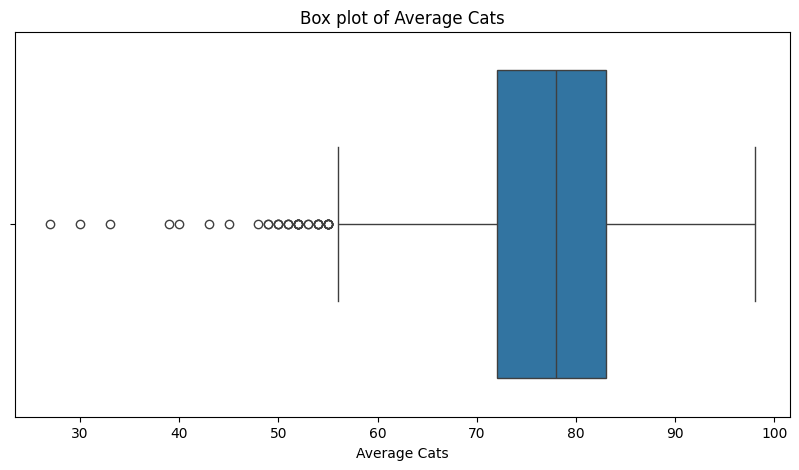

Outliers in Average Handouts:
9       50.0
160     41.0
224     60.0
258     57.0
263     56.0
316     60.0
458     62.0
470     59.0
545     58.0
566     62.0
617     47.0
740     55.0
769     62.0
882     61.0
978     63.0
1129    54.0
1256    53.0
1317    44.0
1500    50.0
1605    62.0
1642    62.0
1651    62.0
1725    50.0
1838    53.0
1855    61.0
1856    54.0
1922    45.0
2060    44.0
Name: Average Handouts, dtype: float64


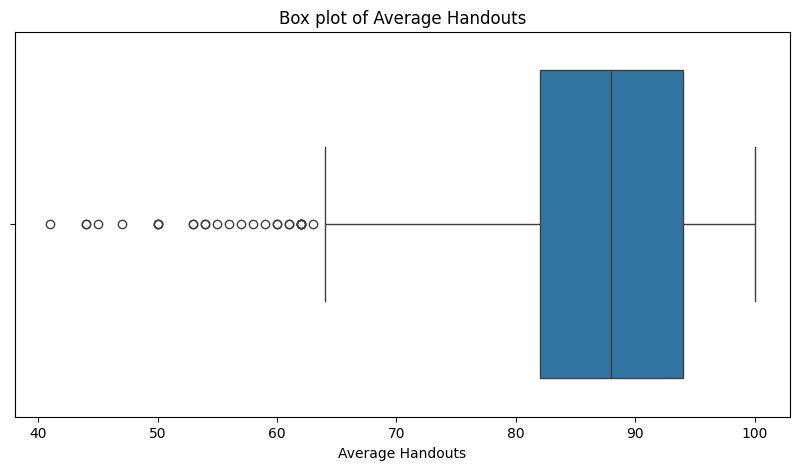

Outliers in Average Practicals:
25      85
30      91
33      92
35      92
36      87
        ..
2194    56
2224    89
2233    92
2241    67
2363    92
Name: Average Practicals, Length: 225, dtype: int64


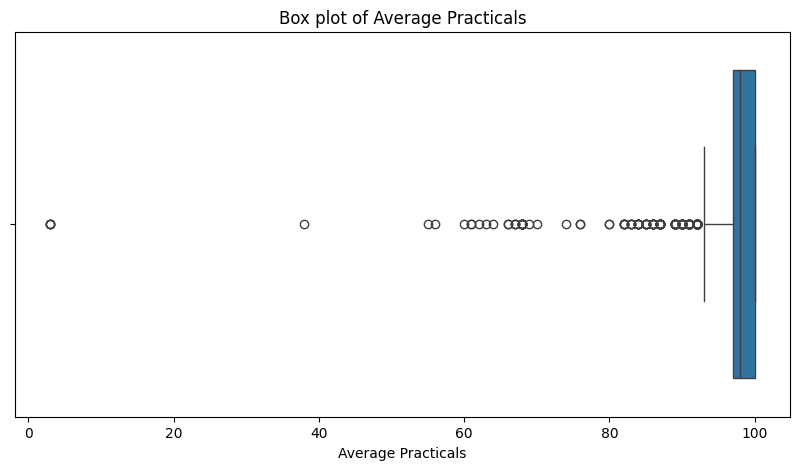

Outliers in Practical-Icare:
1816    49.0
1910    50.0
Name: Practical-Icare, dtype: float64


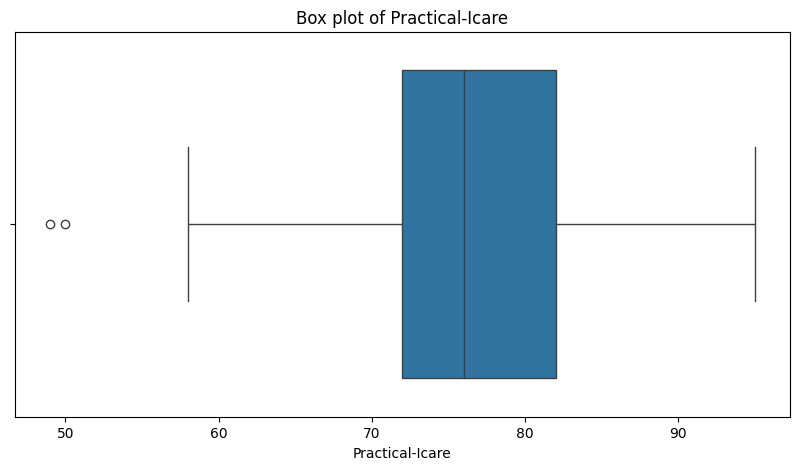

Outliers in Course Duration Months:
78      12
84      12
91      12
93      12
94      12
        ..
2389    12
2390    12
2391    12
2392    12
2393    12
Name: Course Duration Months, Length: 528, dtype: int64


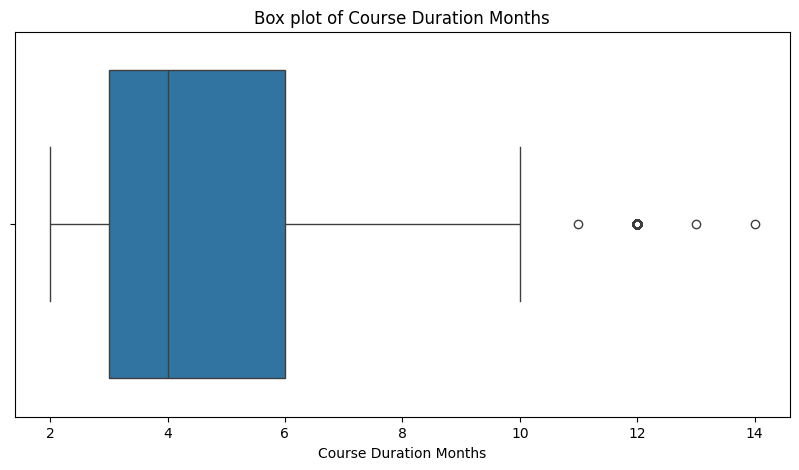

Outliers in Age:
59      51.0
68      55.0
72      51.0
81      52.0
157     51.0
        ... 
1963    53.0
1964    54.0
1974    51.0
2239    47.0
2240    48.0
Name: Age, Length: 79, dtype: float64


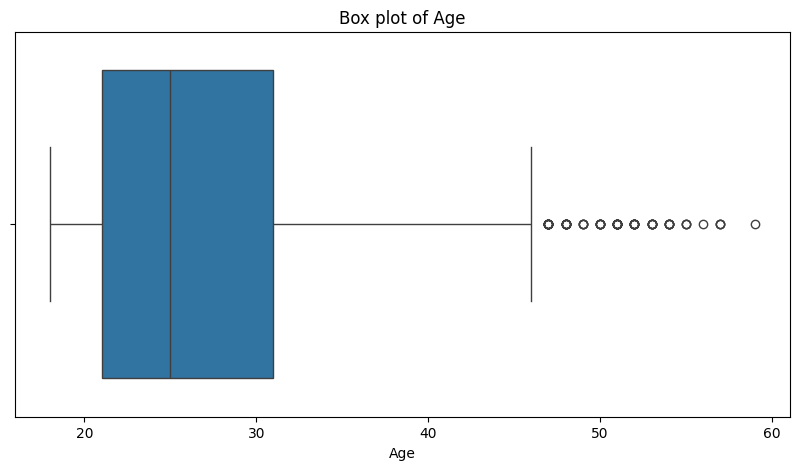

In [ ]:
numerical_cols = df2.select_dtypes(include=['float', 'int'])

# Function to calculate IQR and identify outliers

def identify_outliers(col):

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return col[(col < lower_bound) | (col > upper_bound)]

# Detecting outliers for each numerical column and plotting box plots to proof

for col in numerical_cols:
  outliers = identify_outliers(df2[col])
  print(f"Outliers in {col}:")
  print(outliers)

  # Plotting box plot
  plt.figure(figsize=(10, 5))
  sns.boxplot(x=df2[col])
  plt.title(f'Box plot of {col}')
  plt.show()

### Now apply Winsorization to cap and floor Outliers

In [ ]:
def cap_floor_outliers(df2, col):
    Q1 = df2[col].quantile(0.20)
    Q3 = df2[col].quantile(0.70)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply capping and flooring
    df2[col] = df2[col].clip(lower=lower_bound, upper=upper_bound)

    return df2


for col in numerical_cols:
    df2 = cap_floor_outliers(df2, col)
    print(f'Capped and floored outliers for column {col} successfully')


Capped and floored outliers for column Height successfully
Capped and floored outliers for column Weight successfully
Capped and floored outliers for column Entry Test successfully
Capped and floored outliers for column Theory Exam - Icare successfully
Capped and floored outliers for column Hospital Internship Score successfully
Capped and floored outliers for column Final Score successfully
Capped and floored outliers for column Average Attendance successfully
Capped and floored outliers for column Average Cats successfully
Capped and floored outliers for column Average Handouts successfully
Capped and floored outliers for column Average Practicals successfully
Capped and floored outliers for column Practical-Icare successfully
Capped and floored outliers for column Course Duration Months successfully
Capped and floored outliers for column Age successfully


### Plot to show the Remaining Outliers

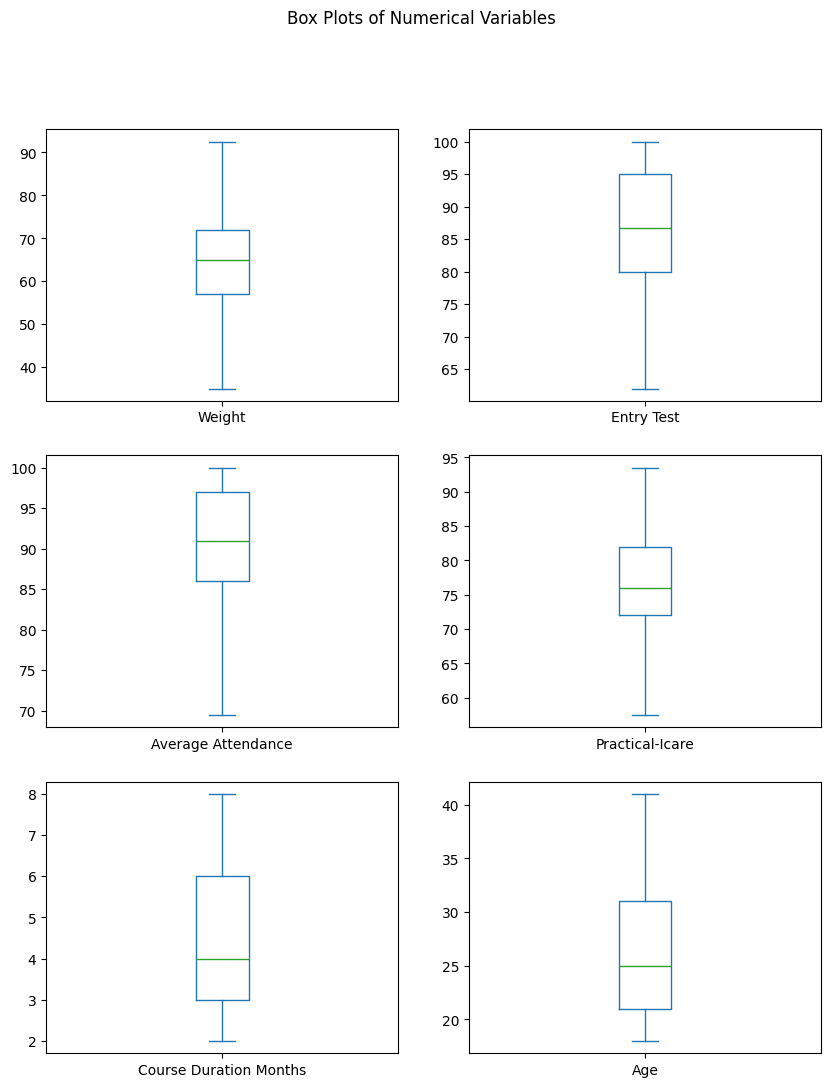

In [ ]:
df2[['Weight','Entry Test','Average Attendance','Practical-Icare','Course Duration Months','Age']].plot(kind='box', subplots=True, layout=(3,2), figsize=(10, 12), title='Box Plots of Numerical Variables')
plt.show()

### Load shapefile Dataset then use it to plot the County boundaries

In [ ]:
import geopandas as gpd
kenya_map = gpd.read_file("/content/County.shp")
df_students = df2.dropna(subset=['County'])
kenya_map['COUNTY'] = kenya_map['COUNTY'].str.upper().str.strip()
df_students['County'] = df_students['County'].str.upper().str.strip()

### Group by County to get student counts

In [ ]:
county_distribution = df_students.groupby('County', as_index=False).size()
county_distribution.rename(columns={'size': 'Student Count'}, inplace=True)

merged = kenya_map.merge(county_distribution, left_on="COUNTY", right_on="County", how="left")
merged['Student Count'] = merged['Student Count'].fillna(0).astype(int)

### Create categorical color mapping

In [ ]:
unique_counts = np.sort(merged['Student Count'].unique())
n_colors = len(unique_counts)

cmap = plt.cm.get_cmap('tab20', n_colors)
color_dict = {count: i for i, count in enumerate(unique_counts)}
merged['color_index'] = merged['Student Count'].map(color_dict)

### Plot the Kenyan map showing the distributions

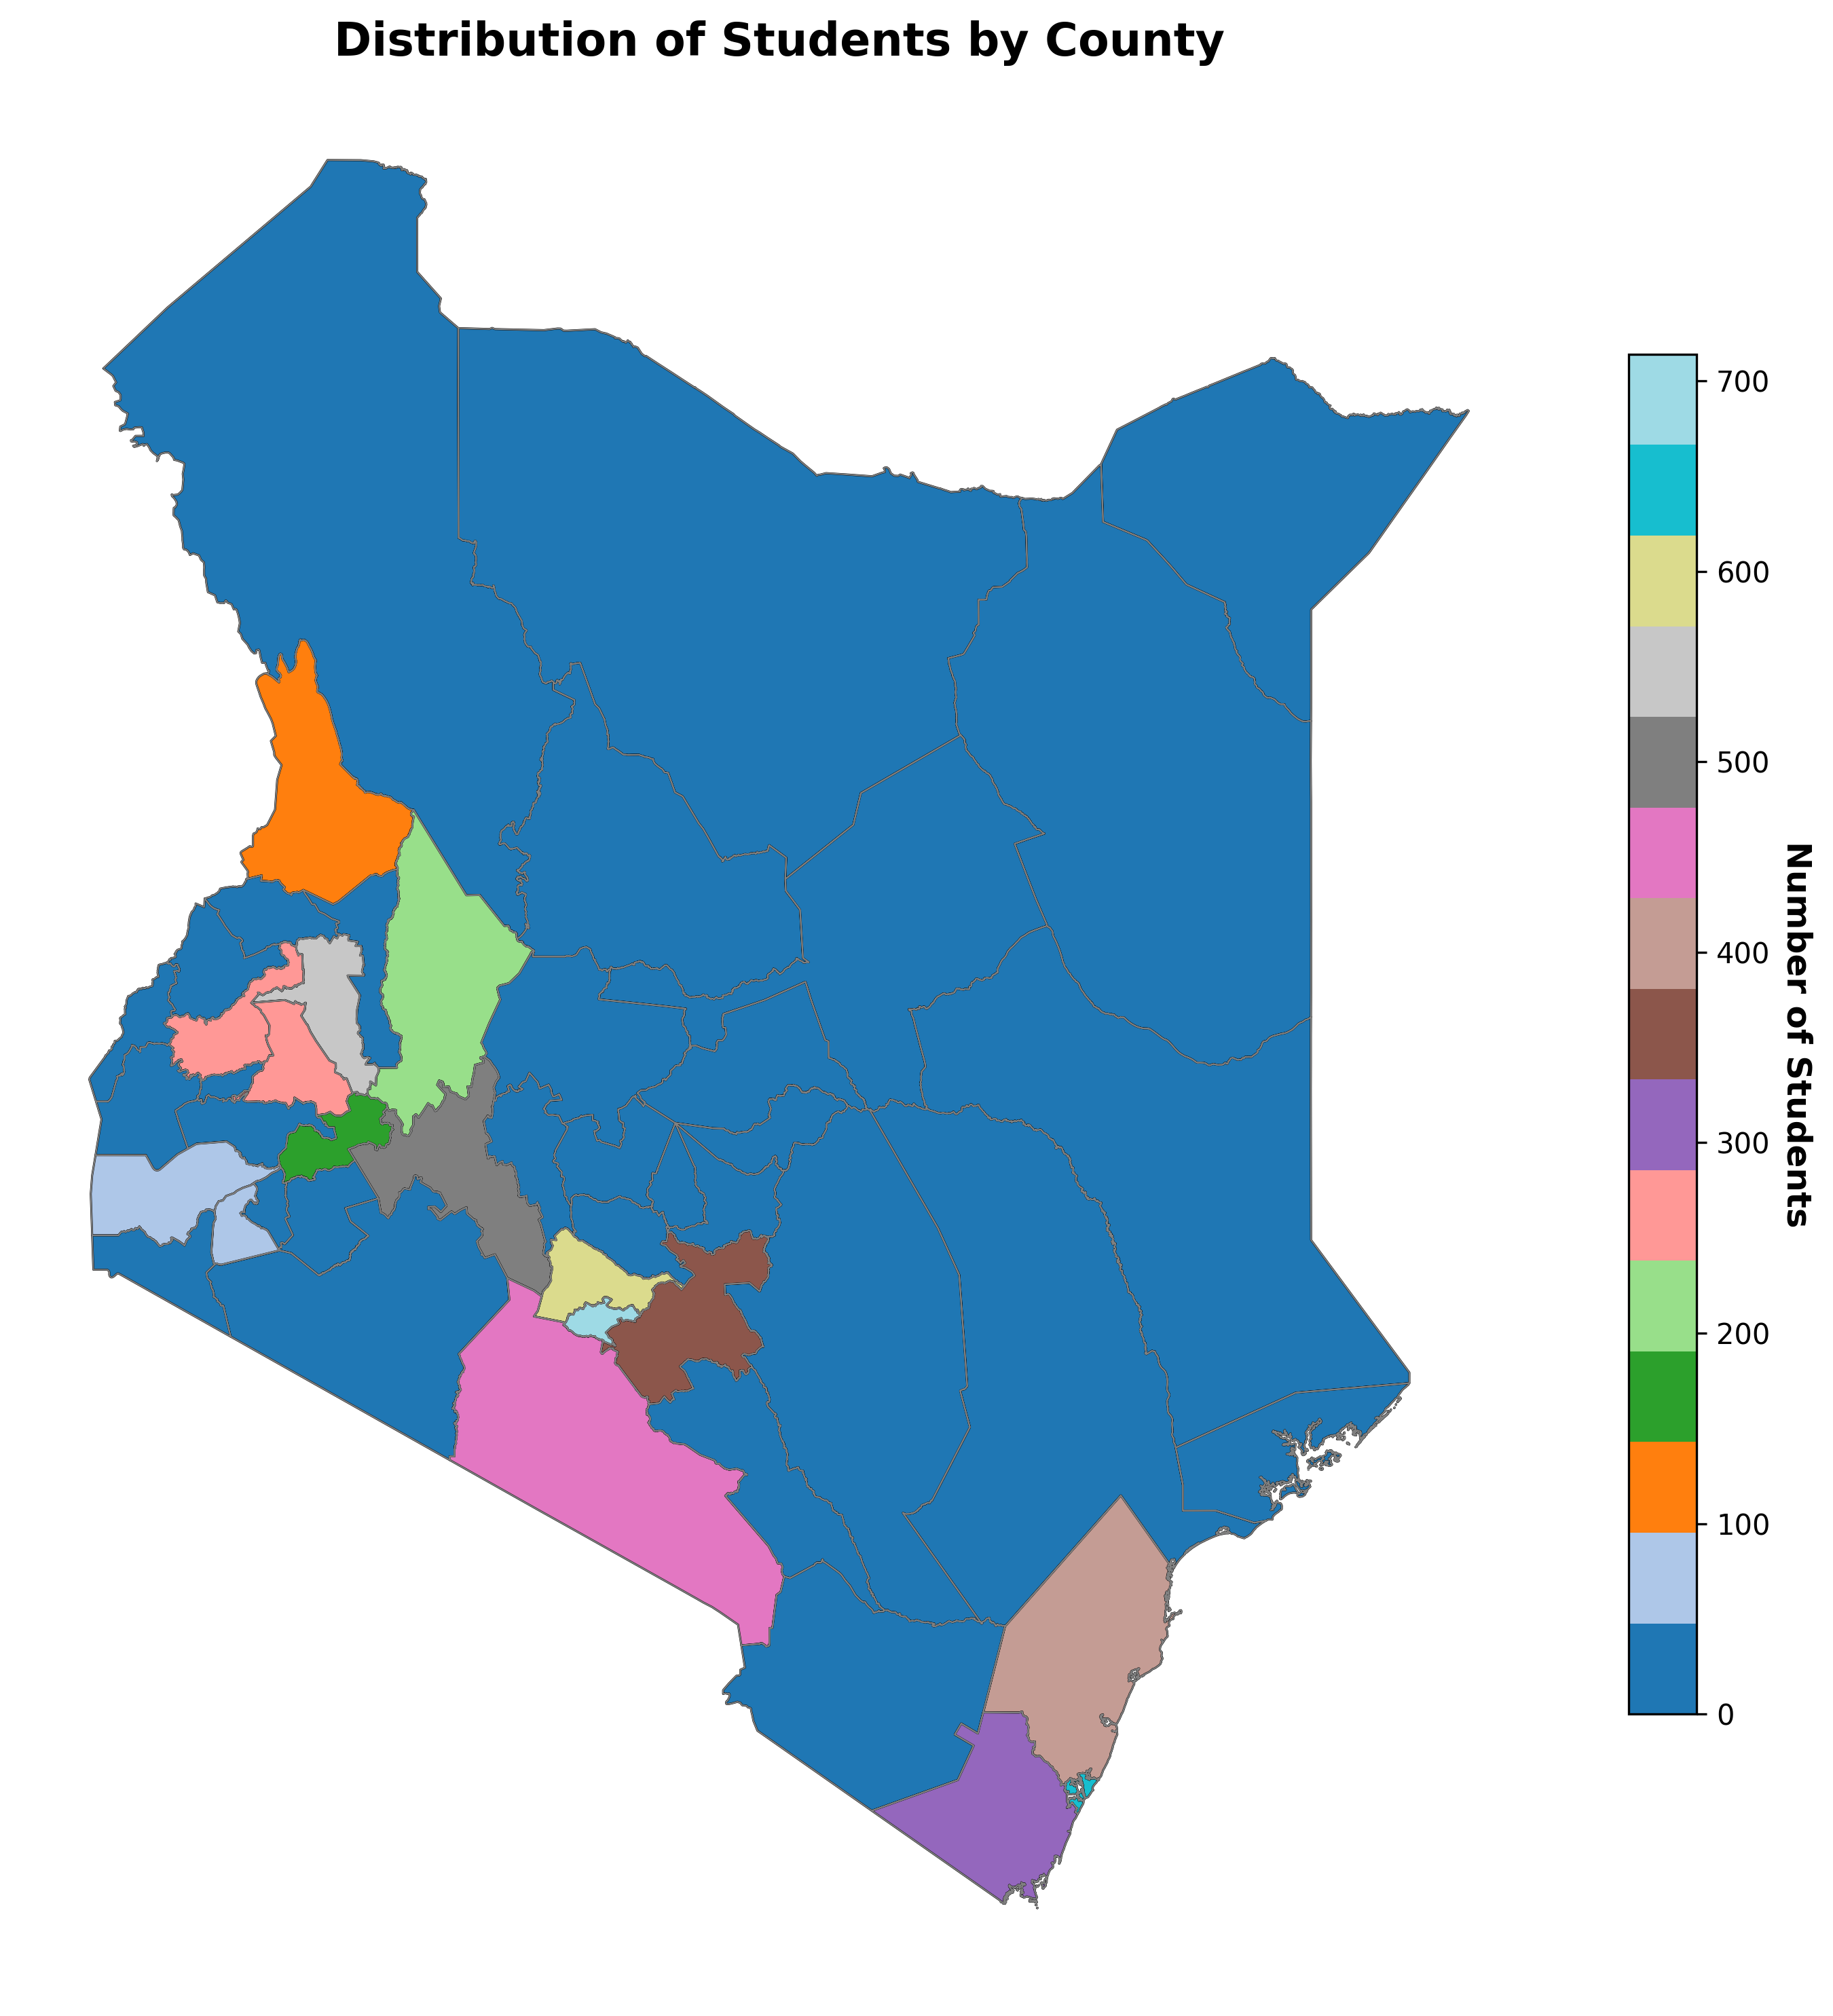

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

kenya_map.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray')

merged.plot(
    ax=ax,
    column='color_index',
    cmap=cmap,
    linewidth=0.7,
    edgecolor='black',
    legend=False
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=unique_counts.min(), vmax=unique_counts.max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)

cbar.set_label("Number of Students", rotation=270, labelpad=15, fontsize=12, fontweight='bold')

plt.title("Distribution of Students by County", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()

plt.savefig("distribution_of_students_by_county.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()


### Age group analysis

In [ ]:
df3 = pd.read_csv("/content/Kenya-Age-Distribution-2020-2025 - Kenya-2024.csv")

In [ ]:
print(df3.head().to_string())
print("\nColumns available:")
print(df3.columns)

     Age  Total 2020  Total 2021  Total 2022  Total 2023  Total 2024  Total 2025
0    0-4     6938210     6949494     6981963     7036696     7110205     7201066
1    5-9     6867367     6830055     6808044     6810726     6824310     6839603
2  10-14     6707567     6809597     6864580     6875446     6853156     6819342
3  15-19     5833755     5997369     6161636     6333838     6498132     6641849
4  20-24     4911291     5066124     5233066     5404730     5572195     5736632

Columns available:
Index(['Age', 'Total 2020', 'Total 2021', 'Total 2022', 'Total 2023',
       'Total 2024', 'Total 2025'],
      dtype='object')


### Elderly and Children under 5 years Population Growth trends in Kenya

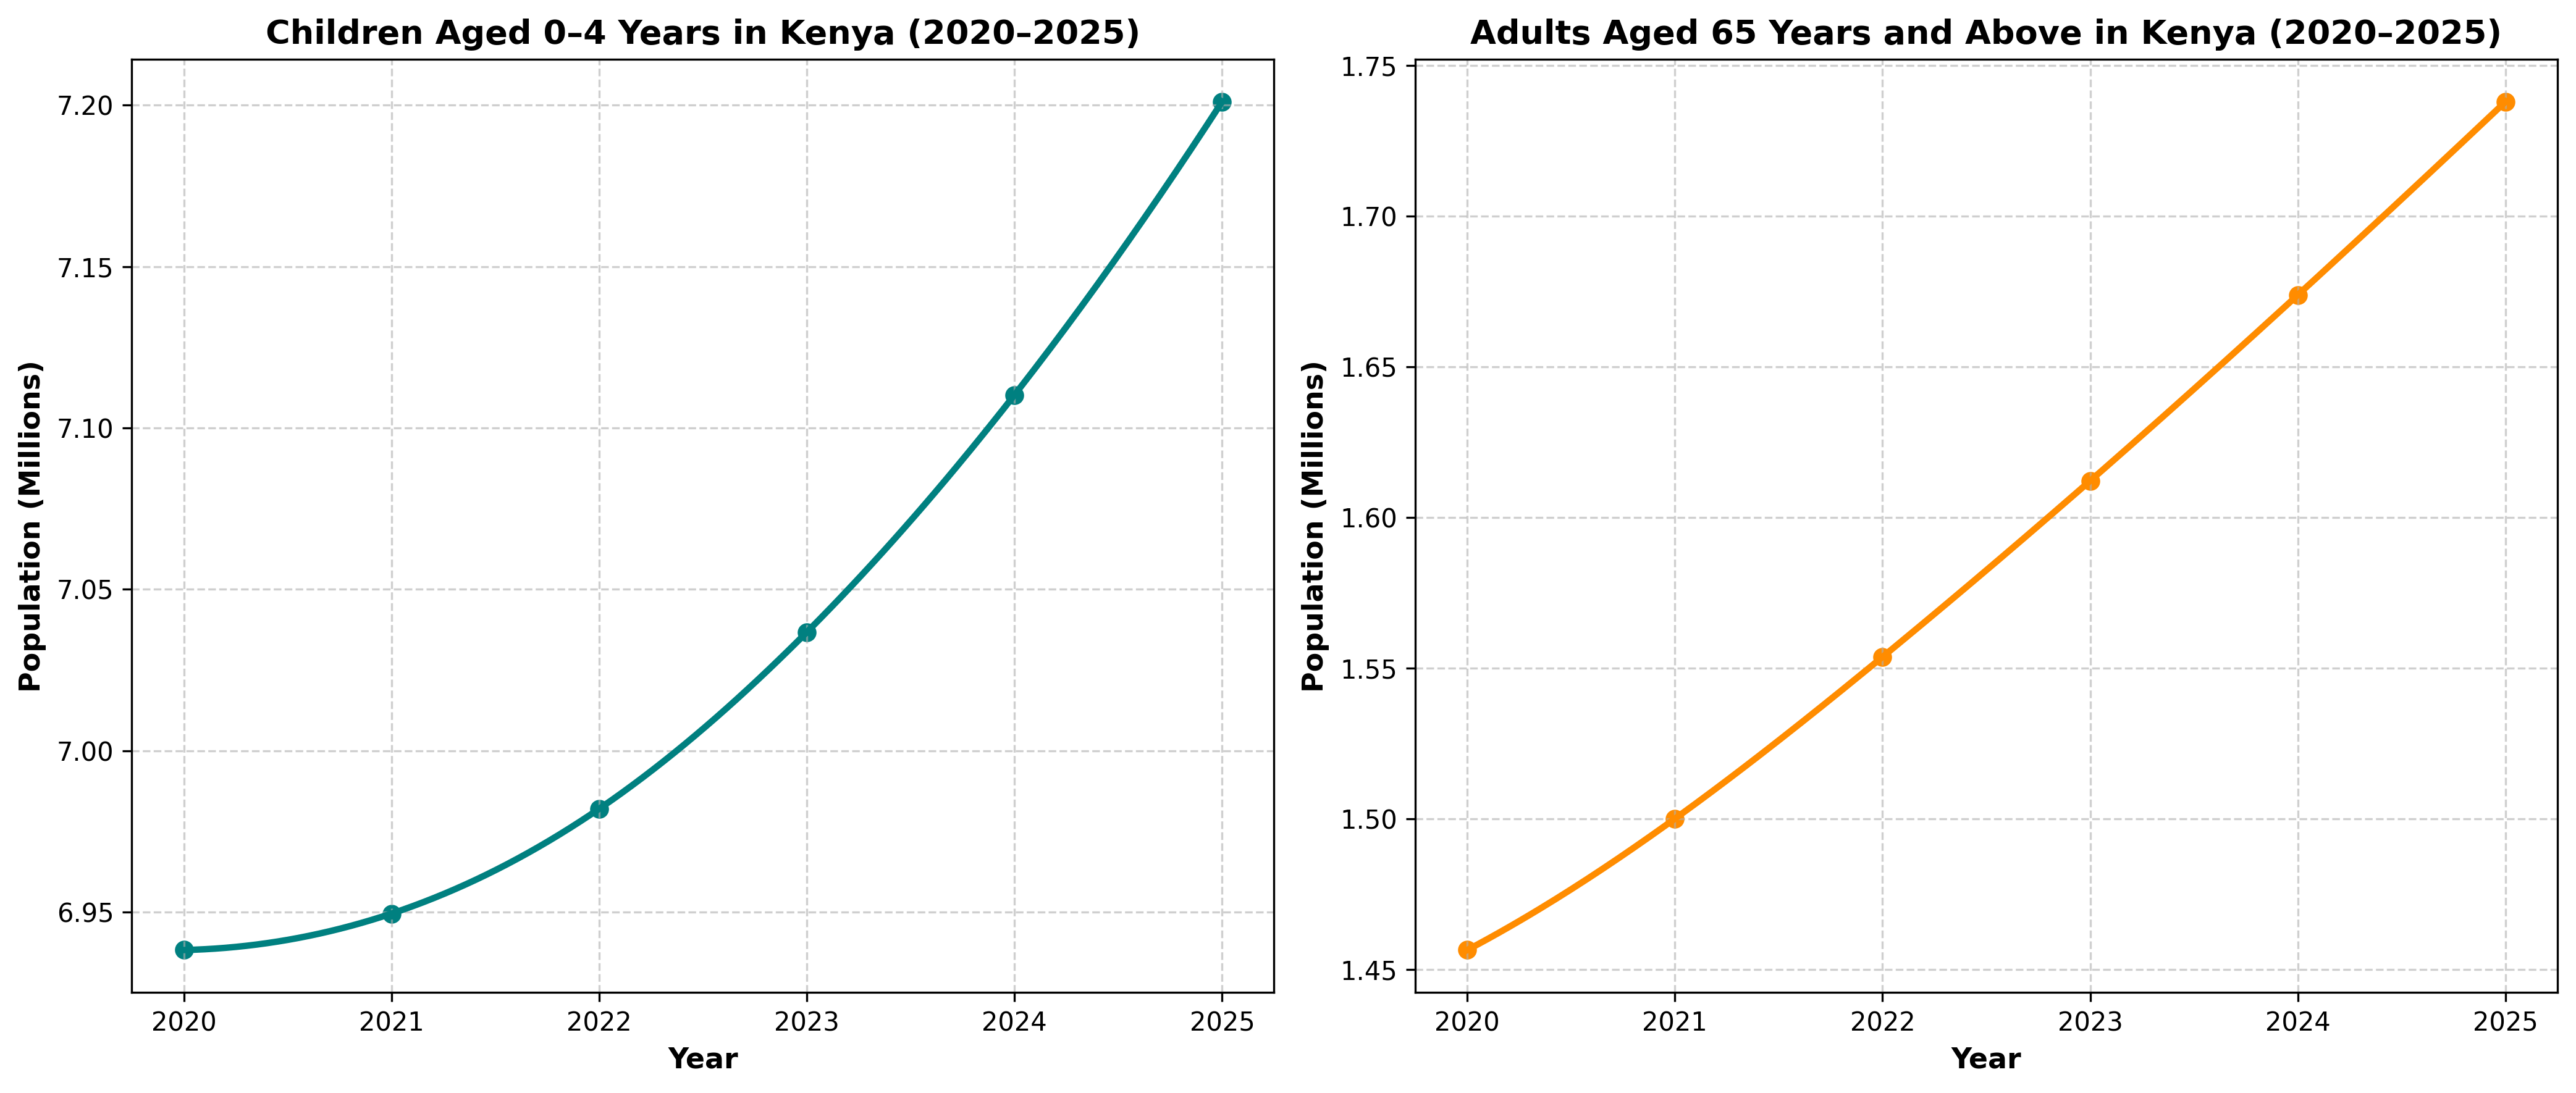

In [ ]:
from scipy.interpolate import make_interp_spline
df_melted = df3.melt(
    id_vars='Age',
    value_vars=['Total 2020', 'Total 2021', 'Total 2022', 'Total 2023', 'Total 2024', 'Total 2025'],
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract('(\d+)').astype(int)
df_melted['Population (Millions)'] = df_melted['Population'] / 1_000_000

# Children (0–4 years)
children_df = df_melted[df_melted['Age'] == '0-4']
x1 = children_df['Year']
y1 = children_df['Population (Millions)']
x1_smooth = np.linspace(x1.min(), x1.max(), 200)
y1_smooth = make_interp_spline(x1, y1)(x1_smooth)

# Elderly (65+ years)
elderly_df = df_melted[df_melted['Age'].isin(['65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+'])]
elderly_summary = elderly_df.groupby('Year')['Population (Millions)'].sum().reset_index()
x2 = elderly_summary['Year']
y2 = elderly_summary['Population (Millions)']
x2_smooth = np.linspace(x2.min(), x2.max(), 200)
y2_smooth = make_interp_spline(x2, y2)(x2_smooth)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Left plot: Children
axes[0].plot(x1_smooth, y1_smooth, color='teal', linewidth=2.5)
axes[0].scatter(x1, y1, color='teal', s=40)
axes[0].set_title("Children Aged 0–4 Years in Kenya (2020–2025)", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Year", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Population (Millions)", fontsize=11, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].ticklabel_format(style='plain', axis='y')

# Right plot: Elderly
axes[1].plot(x2_smooth, y2_smooth, color='darkorange', linewidth=2.5)
axes[1].scatter(x2, y2, color='darkorange', s=40)
axes[1].set_title("Adults Aged 65 Years and Above in Kenya (2020–2025)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Year", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Population (Millions)", fontsize=11, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].ticklabel_format(style='plain', axis='y')

# Adjust layout
plt.tight_layout()
plt.savefig("kenya_population_comparison.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()


### Recommendations

In [ ]:
print("- Both age groups show increasing population trends, indicating rising caregiving demand.")
print("- For 0–4 years: invest in early childhood development centers, nutrition, and trained caregivers.")
print("- For 65+ years: expand home-based care, geriatric clinics, and social support programs.")
print("- Kenya’s policy should anticipate dual caregiving needs—balancing childcare and eldercare infrastructure.")

- Both age groups show increasing population trends, indicating rising caregiving demand.
- For 0–4 years: invest in early childhood development centers, nutrition, and trained caregivers.
- For 65+ years: expand home-based care, geriatric clinics, and social support programs.
- Kenya’s policy should anticipate dual caregiving needs—balancing childcare and eldercare infrastructure.



### Feature encoding and imputation pipeline


#### Define a helper function

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        self.cols = None  # save column order

    def fit(self, X, y=None):
        # X can be a DataFrame or array
        if isinstance(X, pd.DataFrame):
            self.cols = X.columns
            X_values = X.values
        else:
            self.cols = [f"col_{i}" for i in range(X.shape[1])]
            X_values = X

        for i, col in enumerate(self.cols):
            le = LabelEncoder()
            le.fit(X_values[:, i].astype(str))
            self.encoders[i] = le
        return self

    def transform(self, X):
        X_values = X.copy() if isinstance(X, np.ndarray) else X.values
        X_transformed = np.zeros_like(X_values, dtype=float)

        for i in range(X_values.shape[1]):
            le = self.encoders[i]
            X_transformed[:, i] = le.transform(X_values[:, i].astype(str))

        return X_transformed

### Feature Scaling

#### Target Feature Separation

In [ ]:
target_col = 'Transitioned_to_Caregiving'
X = df2.drop(columns=[target_col]).copy()
y = df2[target_col].copy()

#### Applying label encoder and cleeaning numerical features

In [ ]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', MultiColumnLabelEncoder())
])

preprocessing_pipeline = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Fit and transform
X_processed = preprocessing_pipeline.fit_transform(X)

# Convert to DataFrame then Clean
final_columns = numeric_cols + categorical_cols
X_processed = pd.DataFrame(X_processed, columns=final_columns, index=X.index)
X_processed = X_processed.apply(pd.to_numeric, errors='coerce')
X_processed = X_processed.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X_processed.index]


### Feature Selection using Stepwise method

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05, verbose=True):
    """
    Perform forward-backward feature selection based on AIC and p-values.
    Prints complete model statistics at each step including Coef, Std.Err, t, P>|t|, [0.025, 0.975].
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    included = []
    step = 0

    if verbose:
        print("=== Stepwise Selection (AIC & Statistical Summary) ===\n")

    while True:
        changed = False
        excluded = list(set(range(X.shape[1])) - set(included))
        aic_with_candidates = {}

        # --- Forward Step ---
        for new_idx in excluded:
            model = sm.OLS(y, sm.add_constant(X[:, included + [new_idx]])).fit()
            aic_with_candidates[new_idx] = model.aic

        if not aic_with_candidates:
            break

        best_idx = min(aic_with_candidates, key=aic_with_candidates.get)
        model = sm.OLS(y, sm.add_constant(X[:, included + [best_idx]])).fit()
        best_pvalue = model.pvalues[-1]

        if best_pvalue < threshold_in:
            included.append(best_idx)
            changed = True
            step += 1
            if verbose:
                print(f"\n Step {step}: ADD '{X_processed.columns[best_idx]}'")
                summary_table = model.summary2().tables[1][['Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']]
                print(summary_table)
                print(f"AIC: {model.aic:.3f}")

        # --- Backward Step ---
        if included:
            model = sm.OLS(y, sm.add_constant(X[:, included])).fit()
            pvalues = model.pvalues[1:]  # exclude intercept
            if pvalues.max() > threshold_out:
                worst_idx = included[np.argmax(pvalues)]
                removed_feature = X_processed.columns[worst_idx]
                included.remove(worst_idx)
                changed = True
                step += 1
                if verbose:
                    print(f"\n Step {step}: REMOVE '{removed_feature}' (p={pvalues.max():.4f})")
                    summary_table = model.summary2().tables[1][['Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']]
                    print(summary_table)
                    print(f"AIC: {model.aic:.3f}")

        if not changed:
            break

    # --- Final Model ---
    final_model = sm.OLS(y, sm.add_constant(X[:, included])).fit()
    if verbose:
        print("\n=== Final Model Summary ===")
        summary_table = final_model.summary2().tables[1][['Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']]
        print(summary_table)
        print(f"Final AIC: {final_model.aic:.3f}\n")

    # Return both selected features and the final model for later use
    return [X_processed.columns[i] for i in included], final_model


# --- Stepwise Selection Execution ---
y_encoded = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
stepwise_features, final_model = stepwise_selection(X_processed, y_encoded)

print("\n Selected Features:", stepwise_features)


=== Stepwise Selection (AIC & Statistical Summary) ===


 Step 1: ADD 'Course Duration Months'
          Coef.  Std.Err.          t          P>|t|    [0.025    0.975]
const  0.819910  0.024834  33.015932  4.870141e-197  0.771212  0.868608
x1    -0.049223  0.004911 -10.022297   3.491814e-23 -0.058854 -0.039592
AIC: 3272.007

 Step 2: ADD 'Practical-Icare'
          Coef.  Std.Err.          t         P>|t|    [0.025    0.975]
const -0.334887  0.121566  -2.754773  5.918126e-03 -0.573274 -0.096500
x1    -0.050288  0.004819 -10.435200  5.889081e-25 -0.059738 -0.040838
x2     0.015165  0.001564   9.696011  7.922030e-22  0.012098  0.018231
AIC: 3181.693

 Step 3: ADD 'Final Grade'
          Coef.  Std.Err.          t         P>|t|    [0.025    0.975]
const -0.361129  0.118904  -3.037146  2.414318e-03 -0.594295 -0.127962
x1    -0.046513  0.004726  -9.841336  1.996349e-22 -0.055781 -0.037245
x2     0.017695  0.001548  11.427870  1.766701e-29  0.014659  0.020731
x3    -0.079507  0.007598 -10.464

### Show the selected features

In [ ]:
print("Selected Features:")
print(stepwise_features)

Selected Features:
['Course Duration Months', 'Practical-Icare', 'Final Grade', 'Hospital Internship Score', 'Average Cats', 'Average Attendance', 'Average Practicals', 'Course', 'Location', 'Sub_County', 'Average Handouts', 'County', 'Theory Exam - Icare', 'Final Score']


### Apply Standard Scaler to the selected features

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_final = X_processed[stepwise_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
X_scaled_df = pd.DataFrame(X_scaled, columns=stepwise_features)

### Compute VIF on scaled features

In [ ]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_df.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_scaled_df.values, i)
    for i in range(X_scaled_df.shape[1])
]

print(vif_data)

                      Feature       VIF
0      Course Duration Months  1.076768
1             Practical-Icare  2.449565
2                 Final Grade  1.103693
3   Hospital Internship Score  2.377589
4                Average Cats  2.231225
5          Average Attendance  1.041796
6          Average Practicals  1.129880
7                      Course  1.051604
8                    Location  1.028554
9                  Sub_County  1.093857
10           Average Handouts  2.218727
11                     County  1.079093
12        Theory Exam - Icare  3.532621
13                Final Score  6.886163


### Now use the scaled features for modeling

In [ ]:
X_final_scaled = X_scaled_df
y_final_scaled = y_encoded

### Save the Scaler and the Encoder for Deployment

In [ ]:
with open("scaler_stepwise_features.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
categorical_encoders = preprocessing_pipeline.named_transformers_['cat'].named_steps['encoder'].encoders
with open("categorical_encoders.pkl", "wb") as f:
    pickle.dump(categorical_encoders, f)


# **TEST CASE**


### Oversample using SMOTE


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final_scaled, y_final_scaled)

print("Class balance after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class balance after SMOTE:
1    1405
0    1405
Name: count, dtype: int64



### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


### Evaluation utilities threshold tuning function


In [ ]:
def evaluate_by_threshold(y_true, probs, thresholds=np.linspace(0.01, 0.99, 99)):
    best_f1 = -1
    best_t = 0.5
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    preds_best = (probs >= best_t).astype(int)
    return {
        "best_f1": best_f1,
        "best_threshold": best_t,
        "precision": precision_score(y_true, preds_best),
        "recall": recall_score(y_true, preds_best),
        "accuracy": accuracy_score(y_true, preds_best),
        "f1": f1_score(y_true, preds_best)
    }

def evaluate_all(y_true, probs):
    auc = roc_auc_score(y_true, probs)
    pr_auc = average_precision_score(y_true, probs)
    thr_res = evaluate_by_threshold(y_true, probs)
    return {
        "auc": auc,
        "pr_auc": pr_auc,
        **thr_res
    }

def record_result(results_list, model_name, stage, metrics):
    row = {"model": model_name, "stage": stage}
    row.update(metrics)
    results_list.append(row)

def get_proba(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    elif hasattr(clf, "decision_function"):
        df = clf.decision_function(X)
        return 1 / (1 + np.exp(-df))  # sigmoid
    else:
        return clf.predict(X)

### Define base models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(
        penalty='l2', max_iter=500, random_state=42, class_weight='balanced'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=400, min_samples_split=16, max_depth=5,
        min_samples_leaf=11, max_features='sqrt', n_jobs=-1,
        random_state=42, class_weight='balanced'
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=700, learning_rate=0.1, random_state=42
    ),
    "LightGBM": LGBMClassifier(
        boosting_type="gbdt", num_leaves=29, max_depth=-2,
        learning_rate=0.01, n_estimators=700,
        subsample=1.0, colsample_bytree=1.0,
        reg_alpha=0.0, reg_lambda=1.0, min_child_samples=18,
        objective="binary", random_state=42, n_jobs=-1,
        importance_type="split", verbose=-1
    ),
    "Support Vector Machine": SVC(
        kernel='rbf', probability=True, C=1.0,
        gamma='scale', random_state=42, class_weight='balanced'
    ),
    "XGBoost": XGBClassifier(
        n_estimators=700, learning_rate=0.03, max_depth=4,
        reg_lambda=2, reg_alpha=1, gamma=0.3, subsample=0.8,
        colsample_bytree=0.8, eval_metric='logloss',
        random_state=42, use_label_encoder=False
    ),
    "Adaboost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=5), n_estimators=500,
        learning_rate=0.01, random_state=42
    ),
    "Catboost": CatBoostClassifier(
        iterations=500, learning_rate=0.01, depth=5,
        l2_leaf_reg=5, border_count=254, eval_metric='Logloss',
        random_state=42, verbose=0
    )
}


### Hyperparameter search spaces

In [ ]:
param_spaces = {

    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 5, 10, 20],
        "penalty": ["l2", "l1", "elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0, 0.25, 0.5, 0.75]
    },

    "Random Forest": {
        "n_estimators": [300, 600, 1000, 1500],
        "max_depth": [None, 6, 10, 15],
        "min_samples_leaf": [1, 2, 4, 8],
        "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
        "class_weight": [None]
    },

    "Gradient Boosting": {
        "n_estimators": [500, 1000, 1500, 2000],
        "learning_rate": [0.005, 0.01, 0.02, 0.05],
        "subsample": [0.5, 0.7, 0.9],
        "min_samples_split": [2, 5, 10]
    },

    "LightGBM": {
        "num_leaves": [31, 63, 127, 255],
        "max_depth": [-1, 6, 10],
        "learning_rate": [0.005, 0.01, 0.02],
        "n_estimators": [1000, 2000, 3000],
        "min_child_samples": [5, 10, 20, 50],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_alpha": [0, 1, 5, 10],
        "reg_lambda": [0.5, 1, 5, 10]
    },

    "Support Vector Machine": {
        "C": [0.1, 1, 10, 50, 100],
        "gamma": ["scale", "auto", 0.01, 0.001]
    },

    "XGBoost": {
        "n_estimators": [1000, 2000, 3000],
        "learning_rate": [0.005, 0.01, 0.02],
        "max_depth": [4, 6, 8],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 1, 5],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_alpha": [0, 0.5, 2, 10],
        "reg_lambda": [1, 3, 5, 10]
    },

    "Adaboost": {
        "n_estimators": [300, 600, 1000],
        "learning_rate": [0.001, 0.01, 0.05, 0.1],
        "estimator__max_depth": [1, 3, 5]
    },

    "Catboost": {
        "iterations": [1000, 2000, 3000],
        "learning_rate": [0.005, 0.01, 0.02],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [3, 5, 10, 20],
        "bagging_temperature": [0, 0.5, 1],
        "random_strength": [0, 1, 5]
    }
}


### Training and tuning function

In [ ]:
def train_and_tune(model_name, clf, param_space=None, n_iter=25):
    results = {}
    clf.fit(X_train, y_train)
    probs = get_proba(clf, X_test)
    baseline_metrics = evaluate_all(y_test, probs)
    results["baseline"] = (clf, baseline_metrics)

    if not param_space:
        return results

    # RandomizedSearchCV tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tuner = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_space,
        n_iter=n_iter,
        scoring="average_precision",
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    tuner.fit(X_train, y_train)

    tuned_clf = tuner.best_estimator_
    tuned_probs = get_proba(tuned_clf, X_test)
    tuned_metrics = evaluate_all(y_test, tuned_probs)

    results["tuned"] = (tuned_clf, tuned_metrics, tuner.best_params_)
    return results


### Run training for all models

In [ ]:
results_list = []

for name, model in models.items():
    print(f"\nTraining {name}")
    params = param_spaces.get(name, None)
    res = train_and_tune(name, model, params, n_iter=30)

    base_clf, base_metrics = res["baseline"]
    record_result(results_list, name, "baseline", base_metrics)

    if "tuned" in res:
        tuned_clf, tuned_metrics, best_params = res["tuned"]
        record_result(results_list, name, "tuned", tuned_metrics)
        print(f"{name} tuning complete. Best params: {best_params}")


Training Logistic Regression
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Logistic Regression tuning complete. Best params: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.75, 'C': 20}

Training Random Forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Random Forest tuning complete. Best params: {'n_estimators': 600, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None, 'class_weight': None}

Training Gradient Boosting
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Gradient Boosting tuning complete. Best params: {'subsample': 0.7, 'n_estimators': 1000, 'min_samples_split': 10, 'learning_rate': 0.02}

Training LightGBM
Fitting 5 folds for each of 30 candidates, totalling 150 fits
LightGBM tuning complete. Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 2000, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.005, 'colsample_bytree': 0.6}

Training Support Vector M

### Compile results

In [ ]:
results_df = pd.DataFrame(results_list)
cols = ["model", "stage", "auc", "pr_auc", "f1", "best_f1", "best_threshold", "precision", "recall", "accuracy"]
results_df = results_df[cols]

print("\nFinal Summary (single line):")
print(results_df.sort_values(["model", "stage"]).reset_index(drop=True).to_string(index=False))



Final Summary (single line):
                 model    stage      auc   pr_auc       f1  best_f1  best_threshold  precision   recall  accuracy
              Adaboost baseline 0.875470 0.851028 0.810811 0.810811            0.47   0.732759 0.907473  0.788256
              Adaboost    tuned 0.893390 0.871120 0.833333 0.833333            0.49   0.783699 0.889680  0.822064
              Catboost baseline 0.884019 0.858454 0.820919 0.820919            0.48   0.740000 0.921708  0.798932
              Catboost    tuned 0.919606 0.911586 0.855285 0.855285            0.42   0.787425 0.935943  0.841637
     Gradient Boosting baseline 0.894505 0.866945 0.844517 0.844517            0.37   0.781818 0.918149  0.830961
     Gradient Boosting    tuned 0.904636 0.882835 0.840871 0.840871            0.48   0.794304 0.893238  0.830961
              LightGBM baseline 0.912286 0.904356 0.836538 0.836538            0.38   0.760933 0.928826  0.818505
              LightGBM    tuned 0.918010 0.907873 0.845787

### Identify the best model

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, accuracy_score, f1_score, log_loss,
    confusion_matrix, roc_curve
)
from sklearn.inspection import permutation_importance


best_row = results_df[
    (results_df["model"] == "Catboost") & (results_df["stage"] == "tuned")
].iloc[0]

best_threshold = best_row["best_threshold"]

best_model = res["tuned"][0]

print("\n>>> Best Model: CatBoost (Tuned)")


>>> Best Model: CatBoost (Tuned)


### Model Diagnostic

In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

metrics = {
    "Log Loss": log_loss(y_test, y_pred_proba),
    "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
    "PR-AUC": average_precision_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}
for m, v in metrics.items():
    print(f"{m}: {v:.4f}")

Log Loss: 0.3688
ROC-AUC: 0.9196
PR-AUC: 0.9116
Accuracy: 0.8416
Precision: 0.7874
Recall: 0.9359
F1 Score: 0.8553


### Plot and save the AUC curve for the model

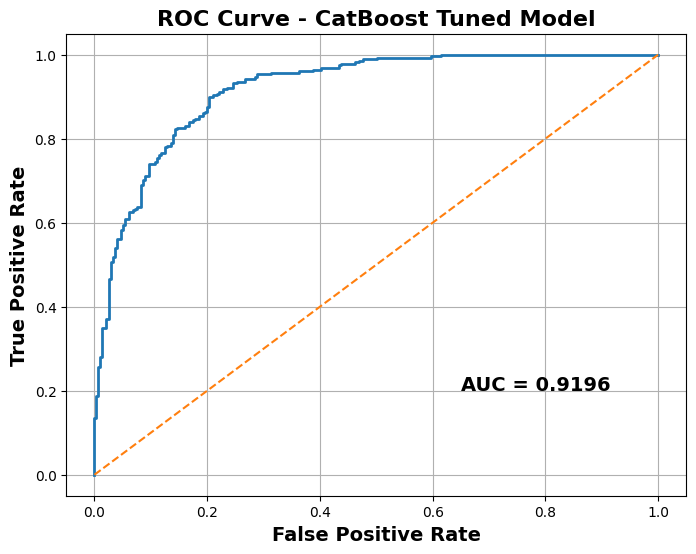

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = metrics["ROC-AUC"]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate", fontsize=14, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=14, fontweight="bold")
plt.title("ROC Curve - CatBoost Tuned Model", fontsize=16, fontweight="bold")
plt.text(0.65, 0.2, f"AUC = {auc_score:.4f}", fontsize=14, fontweight="bold")

plt.grid(True)

plt.savefig("catboost_roc_curve.jpg", dpi=250, bbox_inches="tight")
plt.show()

### Plot the feature importances

                      feature  importance
0      Course Duration Months   10.811214
2                 Final Grade   10.421862
13                Final Score    9.474038
1             Practical-Icare    8.139257
5          Average Attendance    7.977342
6          Average Practicals    7.817454
12        Theory Exam - Icare    7.407289
3   Hospital Internship Score    7.120219
4                Average Cats    6.905672
11                     County    6.133153
9                  Sub_County    6.059586
10           Average Handouts    5.379254
8                    Location    5.183115
7                      Course    1.170545


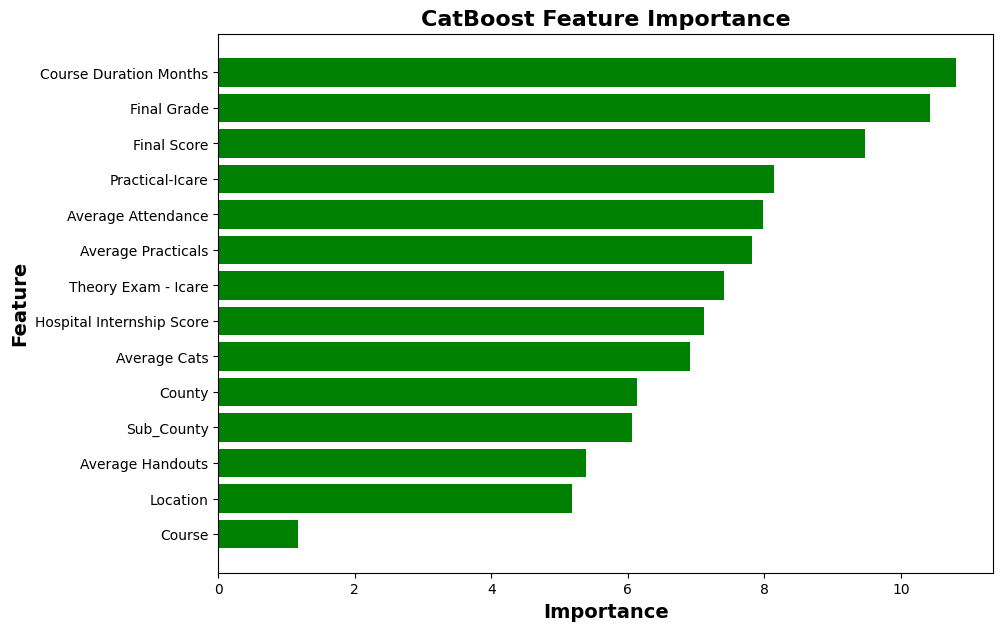

In [ ]:
feature_names = X_final.columns.tolist()

cat_importance = best_model.get_feature_importance()
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": cat_importance
}).sort_values("importance", ascending=False)

print(feat_imp.head(15))

plt.figure(figsize=(10, 7))
plt.barh(
    feat_imp["feature"].head(15),
    feat_imp["importance"].head(15),
    color="green"
)

plt.gca().invert_yaxis()
plt.xlabel("Importance", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("CatBoost Feature Importance", fontsize=16, fontweight="bold")

plt.savefig("catboost_feature_importance.jpg", dpi=250, bbox_inches="tight")
plt.show()

### SHAP Explainability

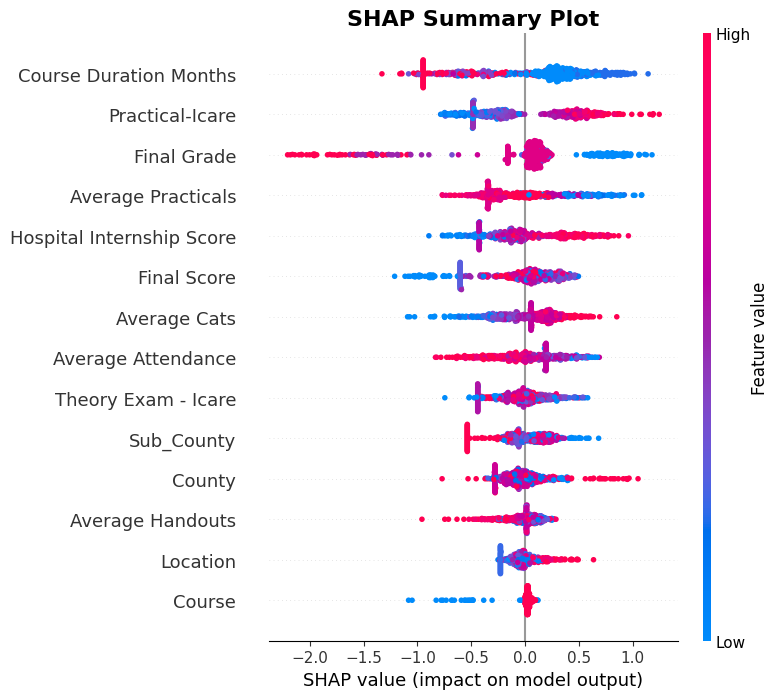

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title("SHAP Summary Plot", fontsize=16, fontweight="bold")
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.savefig("shap_summary_plot.jpg", dpi=250, bbox_inches="tight")
plt.show()


### Confusion Matrix

          Pred 0  Pred 1
Actual 0     210      71
Actual 1      18     263


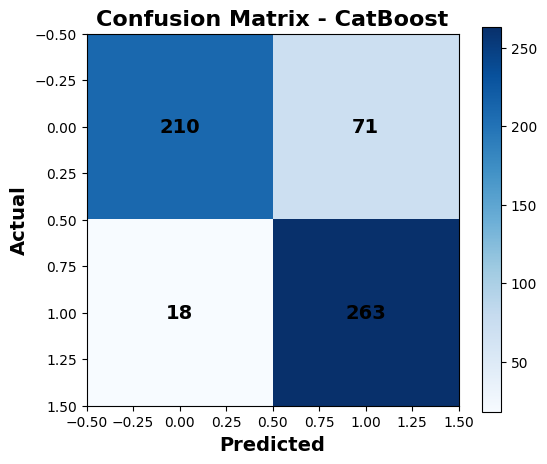

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

print(cm_df)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")

plt.title("Confusion Matrix - CatBoost", fontsize=16, fontweight="bold")
plt.xlabel("Predicted", fontsize=14, fontweight="bold")
plt.ylabel("Actual", fontsize=14, fontweight="bold")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=14, fontweight="bold")

plt.colorbar()
plt.savefig("catboost_confusion_matrix.jpg", dpi=250, bbox_inches="tight")
plt.show()


### Extract the top feature importances

In [ ]:
cat_importance = best_model.get_feature_importance()
feature_names = X_final.columns.tolist()

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": cat_importance
}).sort_values("importance", ascending=False)

print("\nTop feature importance")
print(feat_imp_df.head(20))


Top feature importance
                      feature  importance
0      Course Duration Months   10.811214
2                 Final Grade   10.421862
13                Final Score    9.474038
1             Practical-Icare    8.139257
5          Average Attendance    7.977342
6          Average Practicals    7.817454
12        Theory Exam - Icare    7.407289
3   Hospital Internship Score    7.120219
4                Average Cats    6.905672
11                     County    6.133153
9                  Sub_County    6.059586
10           Average Handouts    5.379254
8                    Location    5.183115
7                      Course    1.170545


### Save the top features as a pickle

In [ ]:
TOP_N = 15

top_features_list = feat_imp_df["feature"].head(TOP_N).tolist()

print(f"\nTop {TOP_N} features selected for deployment:")
print(top_features_list)

with open("top_features.pkl", "wb") as f:
    pickle.dump(top_features_list, f)

print("\n>>> Saved TOP features as 'top_features.pkl'")


Top 15 features selected for deployment:
['Course Duration Months', 'Final Grade', 'Final Score', 'Practical-Icare', 'Average Attendance', 'Average Practicals', 'Theory Exam - Icare', 'Hospital Internship Score', 'Average Cats', 'County', 'Sub_County', 'Average Handouts', 'Location', 'Course']

>>> Saved TOP features as 'top_features.pkl'


### Save the Tuned CatBoost as a pickle

In [ ]:
model_filename = "catboost_tuned_model.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

print(f">>> CatBoost tuned model saved as '{model_filename}'")


>>> CatBoost tuned model saved as 'catboost_tuned_model.pkl'


### Now use the model and the top features to do a prediction

In [ ]:
model = pickle.load(open("catboost_tuned_model.pkl", "rb"))
top_features = pickle.load(open("top_features.pkl", "rb"))

print(top_features)
X_test_top = X_test[top_features]     # Select only the top features
y_test_true = y_test.reset_index(drop=True)

best_threshold = best_row["best_threshold"]

y_pred_proba = model.predict_proba(X_test_top)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

results_df = pd.DataFrame({
    "True Label": y_test_true,
    "Predicted": y_pred,
    "Probability": y_pred_proba
})
results_df = results_df.sort_values("Probability", ascending=False)

print("\n Top true vs predicted values")
print(results_df.head(30).to_string(index=False))



['Course Duration Months', 'Final Grade', 'Final Score', 'Practical-Icare', 'Average Attendance', 'Average Practicals', 'Theory Exam - Icare', 'Hospital Internship Score', 'Average Cats', 'County', 'Sub_County', 'Average Handouts', 'Location', 'Course']

 Top true vs predicted values
 True Label  Predicted  Probability
          1          1     0.985420
          1          1     0.981362
          1          1     0.978474
          1          1     0.972711
          1          1     0.968812
          1          1     0.967262
          1          1     0.965208
          1          1     0.965029
          1          1     0.964696
          1          1     0.962863
          1          1     0.960264
          1          1     0.959717
          1          1     0.956081
          1          1     0.955075
          1          1     0.954808
          1          1     0.952028
          1          1     0.950324
          1          1     0.948952
          1          1     0.94